In [44]:
import requests
import quandl
import datetime
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import math as mt
from matplotlib import pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates
yf.pdr_override()
%matplotlib inline

<h2>Scenario 1 - Money at a fixed rate for an unsecured purchase (Credit Card Loans & Personal Loan Interest)

<h7>In this analysis, we will look at how different economic factors are connected to credit card and personal loan debt. We want to see how things like GDP growth, interest rates on credit cards and personal loans, U.S. Treasury yields, delinquency rates, and the Federal Reserve's effective rates affect each other. This will help us understand how these factors influence credit card borrowing and the risk of people not being able to pay back their debts.

We will use data from reliable sources like the Federal Reserve Economic Data (FRED) and other financial databases. With Python, we will bring in this data, create visualizations, and analyze it. We will make graphs to show changes over time, how data is spread out, and how different factors are related.

Our main goal is to find out if changes in macro economic factors can cause changes in credit card and personal loan debt. To do this, we will use a Granger causality test, which helps us understand if one thing can predict another.

In [45]:
def macroeconomic_datas(file, columns_rename):
    df = pd.read_csv(file)
    df.set_index("DATE", inplace=True)
    df.columns = columns_rename
    print(df.shape)
    print(df.head())
    return df

In [46]:
delinquency_rate_df = macroeconomic_datas('Credit Card unsecured loan/Delinquency Rate on Credit Card Loans, All Commercial Bank.csv', 
                    ['Delinquency Rate'])

(80, 1)
           Delinquency Rate
DATE                       
1/1/2004               4.21
4/1/2004               4.15
7/1/2004               4.07
10/1/2004              4.03
1/1/2005               3.70


In [47]:
gdp_rate_df = macroeconomic_datas('Publicly traded equity/GDP.csv', ['GDP'])

(80, 1)
                 GDP
DATE                
1/1/2004   11923.447
4/1/2004   12112.815
7/1/2004   12305.307
10/1/2004  12527.214
1/1/2005   12767.286


In [48]:
effective_rate_df = macroeconomic_datas('Credit Card unsecured loan/Effective Rates.csv', ['Effective Rate'])

(80, 1)
           Effective Rate
DATE                     
1/1/2004         1.003333
4/1/2004         1.010000
7/1/2004         1.433333
10/1/2004        1.950000
1/1/2005         2.470000


In [49]:
interest_rate_df = macroeconomic_datas('Credit Card unsecured loan/Commercial Bank Interest Rate on Credit Card.csv',
                   ['interest rate'])

(80, 1)
           interest rate
DATE                    
1/1/2004           12.67
4/1/2004           12.69
7/1/2004           13.02
10/1/2004          12.51
1/1/2005           12.21


In [50]:
market_yield_df = macroeconomic_datas('Credit Card unsecured loan/Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity.csv',
                   ['Market Yield'])

(80, 1)
           Market Yield
DATE                   
1/1/2004       4.877903
4/1/2004       5.355645
7/1/2004       5.068281
10/1/2004      4.874839
1/1/2005       4.764098


In [51]:
personal_loan_rate_df = macroeconomic_datas('Credit Card unsecured loan/Finance Rate on Personal Loans at Commercial Banks.csv',
                   ['Loan Interest Rate'])

(80, 1)
           Loan Interest Rate
DATE                         
1/1/2004                11.88
4/1/2004                11.80
7/1/2004                12.02
10/1/2004               11.84
1/1/2005                12.01


<h3>Visualization of Economic Indicators and Credit Card / Personal Loan Debt Metrics

In this script, we're creating a function to plot multiple economic datasets on separate graphs. Each plot shows a different economic indicator over time, with a red dashed line marking the average value for that indicator. After defining the function, we use it to visualize data like delinquency rates, interest rates, market yields, personal loan rates, GDP growth, and federal fund rates from 2004 to 2023.

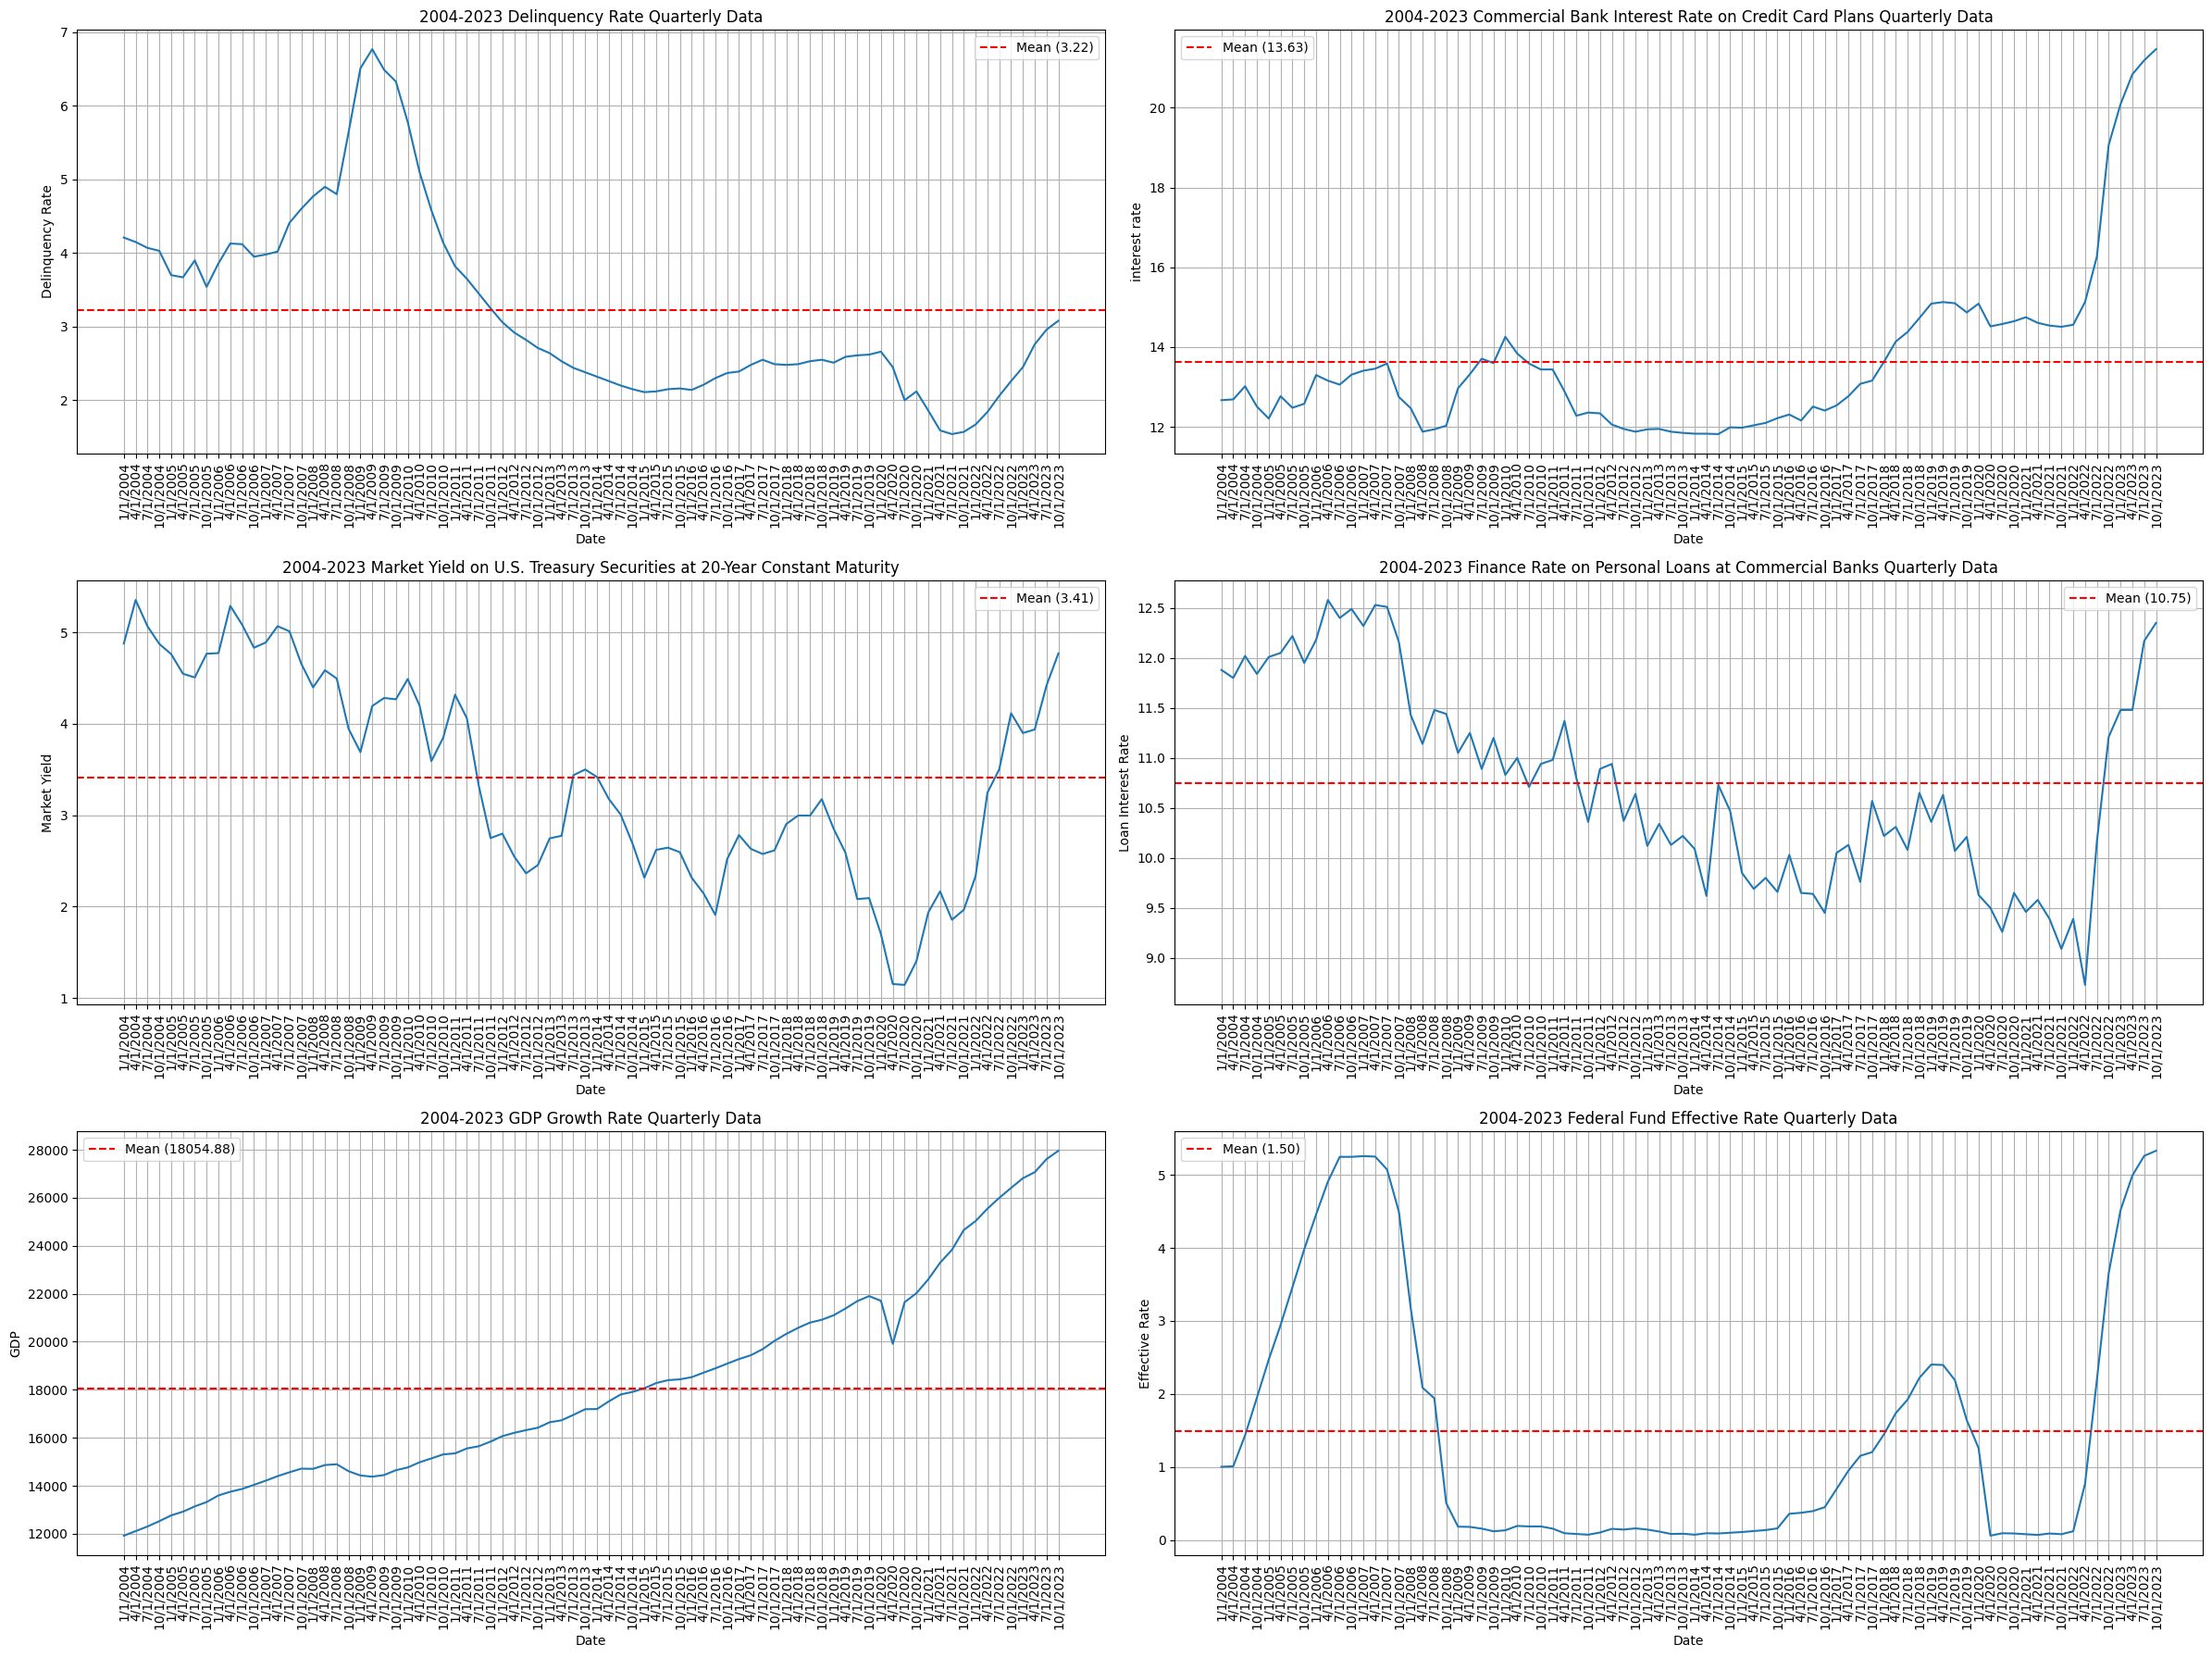

In [52]:
import math

def plot_economic_data(*dfs_titles):
    num_plots = len(dfs_titles)
    nrows = math.ceil(num_plots / 2)
    ncols = 2 if num_plots > 1 else 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 6 * nrows))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (df, title) in enumerate(dfs_titles):
        mean_value = df.iloc[:, 0].mean()

        axes[i].plot(df.index, df.values)
        axes[i].set_title(title)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(df.columns[0])
        axes[i].axhline(y=mean_value, color='red', linestyle='--', label=f'Mean ({mean_value:.2f})')
        axes[i].legend()
        axes[i].grid(True)
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_economic_data(
    (delinquency_rate_df, '2004-2023 Delinquency Rate Quarterly Data'),
    (interest_rate_df, '2004-2023 Commercial Bank Interest Rate on Credit Card Plans Quarterly Data'),
    (market_yield_df, '2004-2023 Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity'),
    (personal_loan_rate_df, '2004-2023 Finance Rate on Personal Loans at Commercial Banks Quarterly Data'),
    (gdp_rate_df, '2004-2023 GDP Growth Rate Quarterly Data'),
    (effective_rate_df, '2004-2023 Federal Fund Effective Rate Quarterly Data')
)

In [53]:
def volatility(*dfs):
    processed_dfs = []    
    for df in dfs:
        processed_df = (df.pct_change().dropna()) * 100
        processed_dfs.append(processed_df)   
    merged_df = pd.concat(processed_dfs, axis=1)
    return merged_df
    
volatility(delinquency_rate_df, interest_rate_df, market_yield_df, personal_loan_rate_df, gdp_rate_df, effective_rate_df)

Delinquency Rate  interest rate  Market Yield  Loan Interest Rate  \
DATE                                                                           
4/1/2004          -1.425178       0.157853      9.794002           -0.673401   
7/1/2004          -1.927711       2.600473     -5.365626            1.864407   
10/1/2004         -0.982801      -3.917051     -3.816729           -1.497504   
1/1/2005          -8.188586      -2.398082     -2.271672            1.435811   
4/1/2005          -0.810811       4.586405     -4.520233            0.333056   
...                     ...            ...           ...                 ...   
10/1/2022          9.708738      17.209588     17.514560           10.334646   
1/1/2023           8.407080       5.348715     -5.275877            2.408564   
4/1/2023          12.653061       3.733201      0.997258            0.000000   
7/1/2023           7.246377       1.679463     12.255179            6.010453   
10/1/2023          4.054054       1.321378      7.909219            1.479047   

                GDP  Effective Rate  
DATE                                 
4/1/2004   1.588198        0.664452  
7/1/2004   1.589160       41.914191  
10/1/2004  1.803344       36.046512  
1/1/2005   1.916404       26.666667  
4/1/2005   1.216938       19.163293  
...             ...             ...  
10/1/2022  1.591736       66.818874  
1/1/2023   1.534345       23.631387  
4/1/2023   0.930166       10.479705  
7/1/2023   2.021638        5.410822  
10/1/2023  1.256314        1.330798  

[79 rows x 6 columns]

<h3>Visualization of Volatility Economic Indicators and Credit Card / Personal Loan Debt Metrics

In this script, we're creating a function to plot the volatility of several economic indicators. We calculate the rolling standard deviation (volatility) for each dataset and standardize the results to make them comparable. Then, we plot these standardized volatilities on a single graph to show how they change over time.

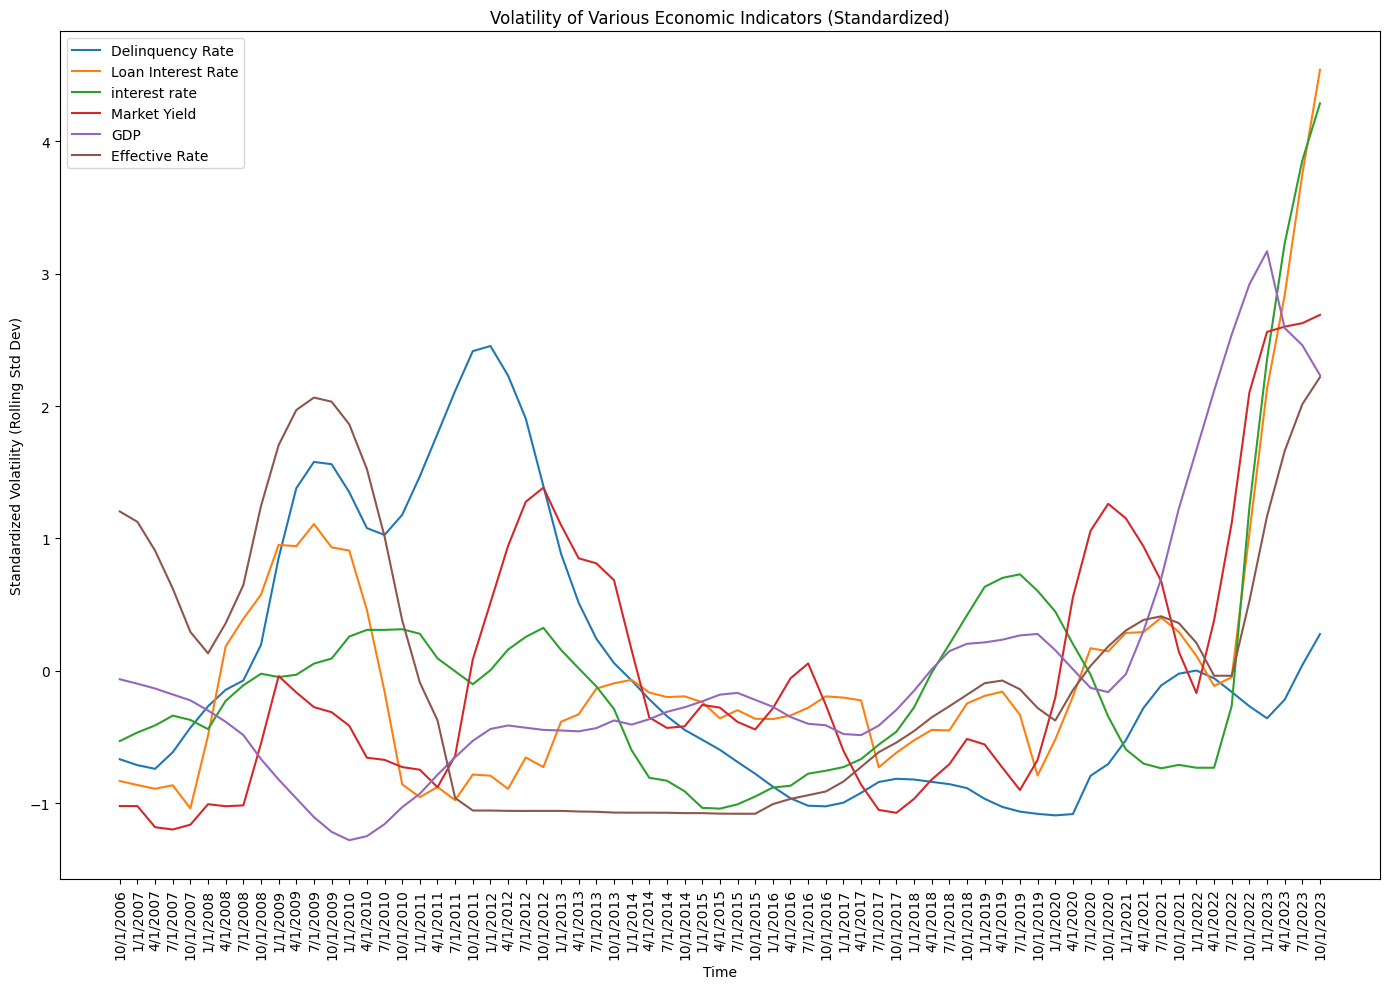

In [54]:
from sklearn.preprocessing import StandardScaler

def volatility_chart(*dfs, window=12):
    plt.figure(figsize=(14, 10))
    
    scaler = StandardScaler()
    for i, df in enumerate(dfs):
        volatility = df.rolling(window=window).std().dropna()
        standardized_volatility = scaler.fit_transform(volatility)
        
        plt.plot(volatility.index, standardized_volatility, label=df.columns[0])
        
    plt.title('Volatility of Various Economic Indicators (Standardized)')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Standardized Volatility (Rolling Std Dev)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
volatility_chart(
    delinquency_rate_df, personal_loan_rate_df, interest_rate_df,
    market_yield_df, gdp_rate_df, effective_rate_df
)

In this script, we are creating histograms to check the distribution of volatility for several economic indicators. Each histogram shows how frequently different levels of volatility occur for indicators like delinquency rates, interest rates, market yields, personal loan rates, GDP growth, and the federal fund rate. This helps us understand the variability and distribution of these economic factors over time.

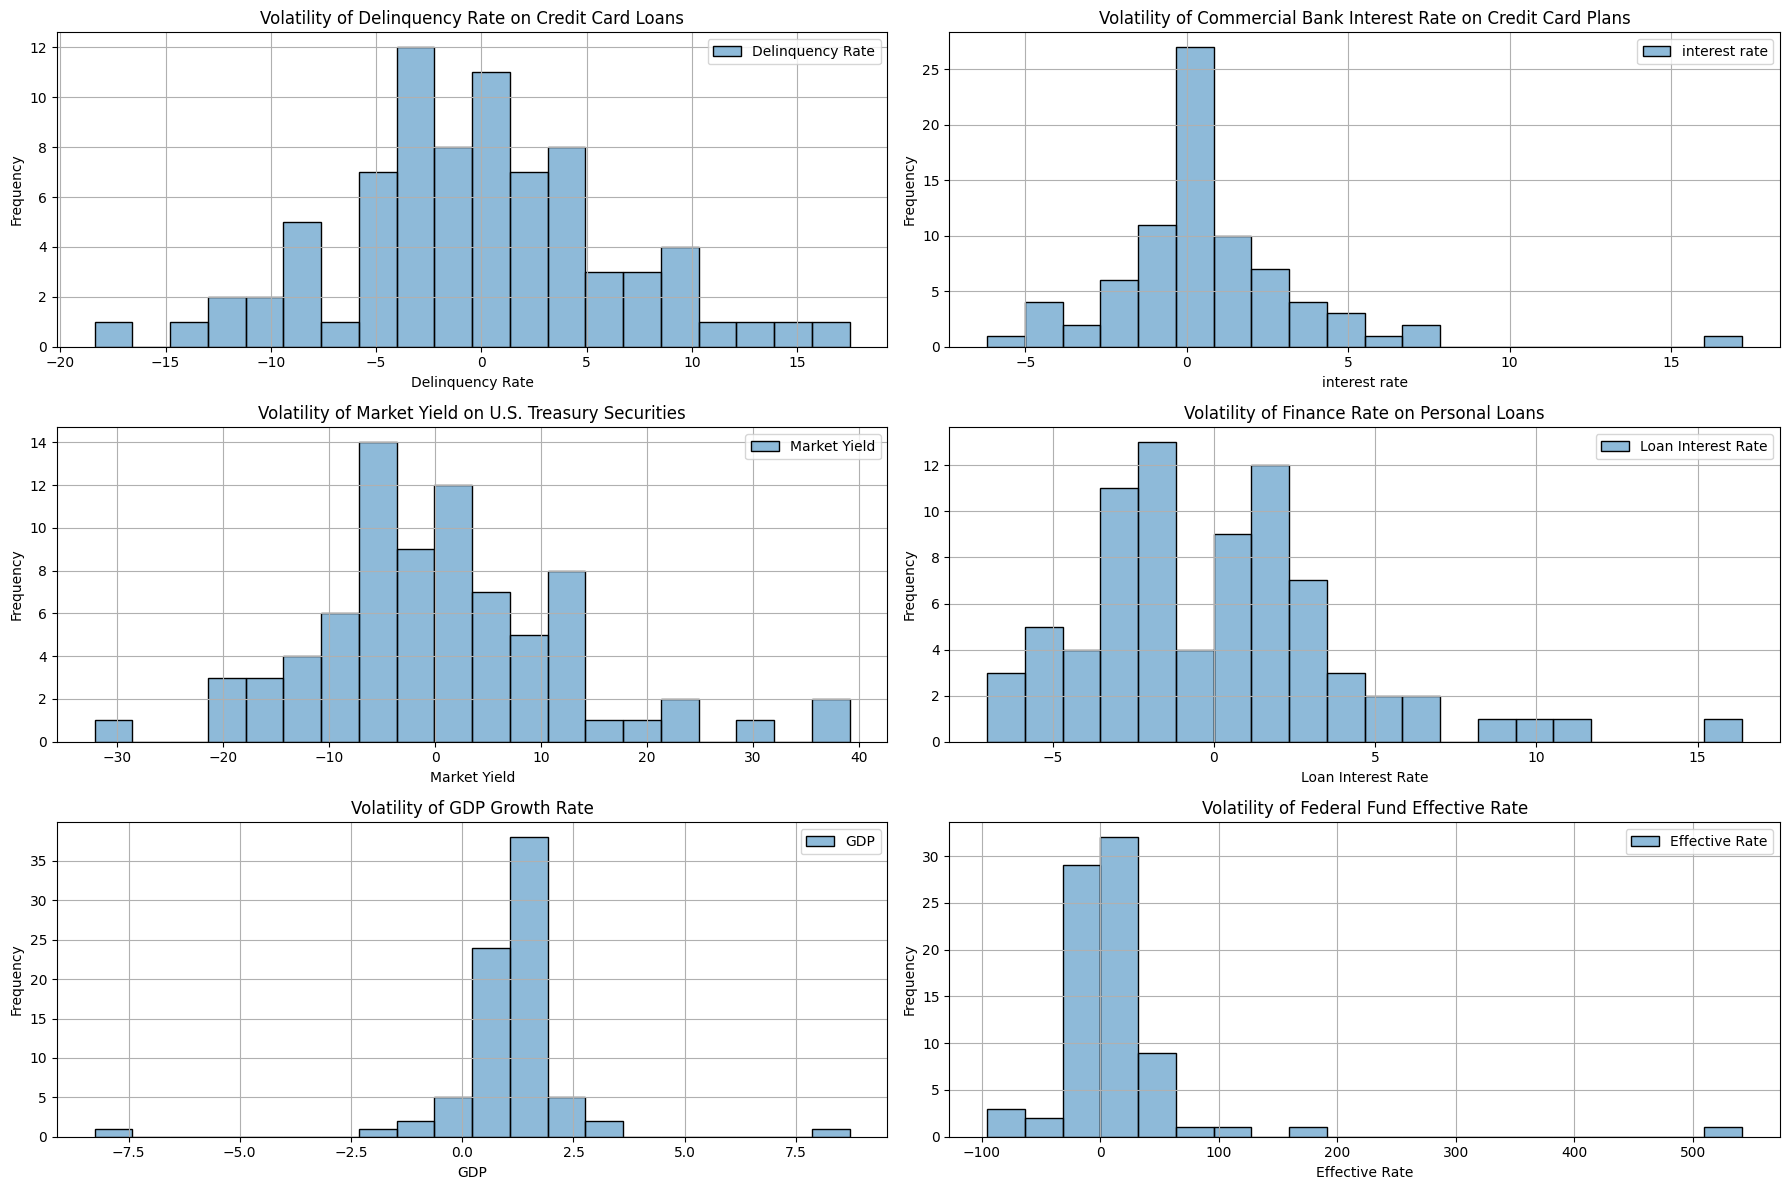

In [55]:
volatility_df = volatility(delinquency_rate_df, interest_rate_df, market_yield_df, personal_loan_rate_df, gdp_rate_df, effective_rate_df)

market_yield_title = 'Volatility of Market Yield on U.S. Treasury Securities'
personal_loan_rate_title = 'Volatility of Finance Rate on Personal Loans'
delinquency_rate_title = 'Volatility of Delinquency Rate on Credit Card Loans'
interest_rate_title = 'Volatility of Commercial Bank Interest Rate on Credit Card Plans'
gdp_rate_title = 'Volatility of GDP Growth Rate'
effective_rate_title = 'Volatility of Federal Fund Effective Rate'

def plot_economic_distributions(*dfs_and_titles):
    num_plots = len(dfs_and_titles)
    ncols = 2
    nrows = (num_plots + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))

    for idx, (df, title) in enumerate(dfs_and_titles):
        row = idx // ncols
        col = idx % ncols
        sns.histplot(df, bins=20, alpha=0.5, color='blue', edgecolor='black', ax=axes[row, col])
        axes[row, col].set_title(title)
        axes[row, col].set_xlabel(df.columns[0]) 
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].grid(True)

    plt.tight_layout()
    plt.show()

plot_data = [
    (volatility_df[['Delinquency Rate']], delinquency_rate_title),
    (volatility_df[['interest rate']], interest_rate_title),
    (volatility_df[['Market Yield']], market_yield_title),
    (volatility_df[['Loan Interest Rate']], personal_loan_rate_title),
    (volatility_df[['GDP']], gdp_rate_title),
    (volatility_df[['Effective Rate']], effective_rate_title)
]

plot_economic_distributions(*plot_data)

In this script, we are creating KDE (Kernel Density Estimate) plots to visualize the distribution of volatility for several economic indicators. Each plot shows the density of volatility values, helping us understand the variability and concentration of different levels of volatility for indicators like market yield, personal loan rates, delinquency rates, interest rates, GDP growth, and the federal fund rate.

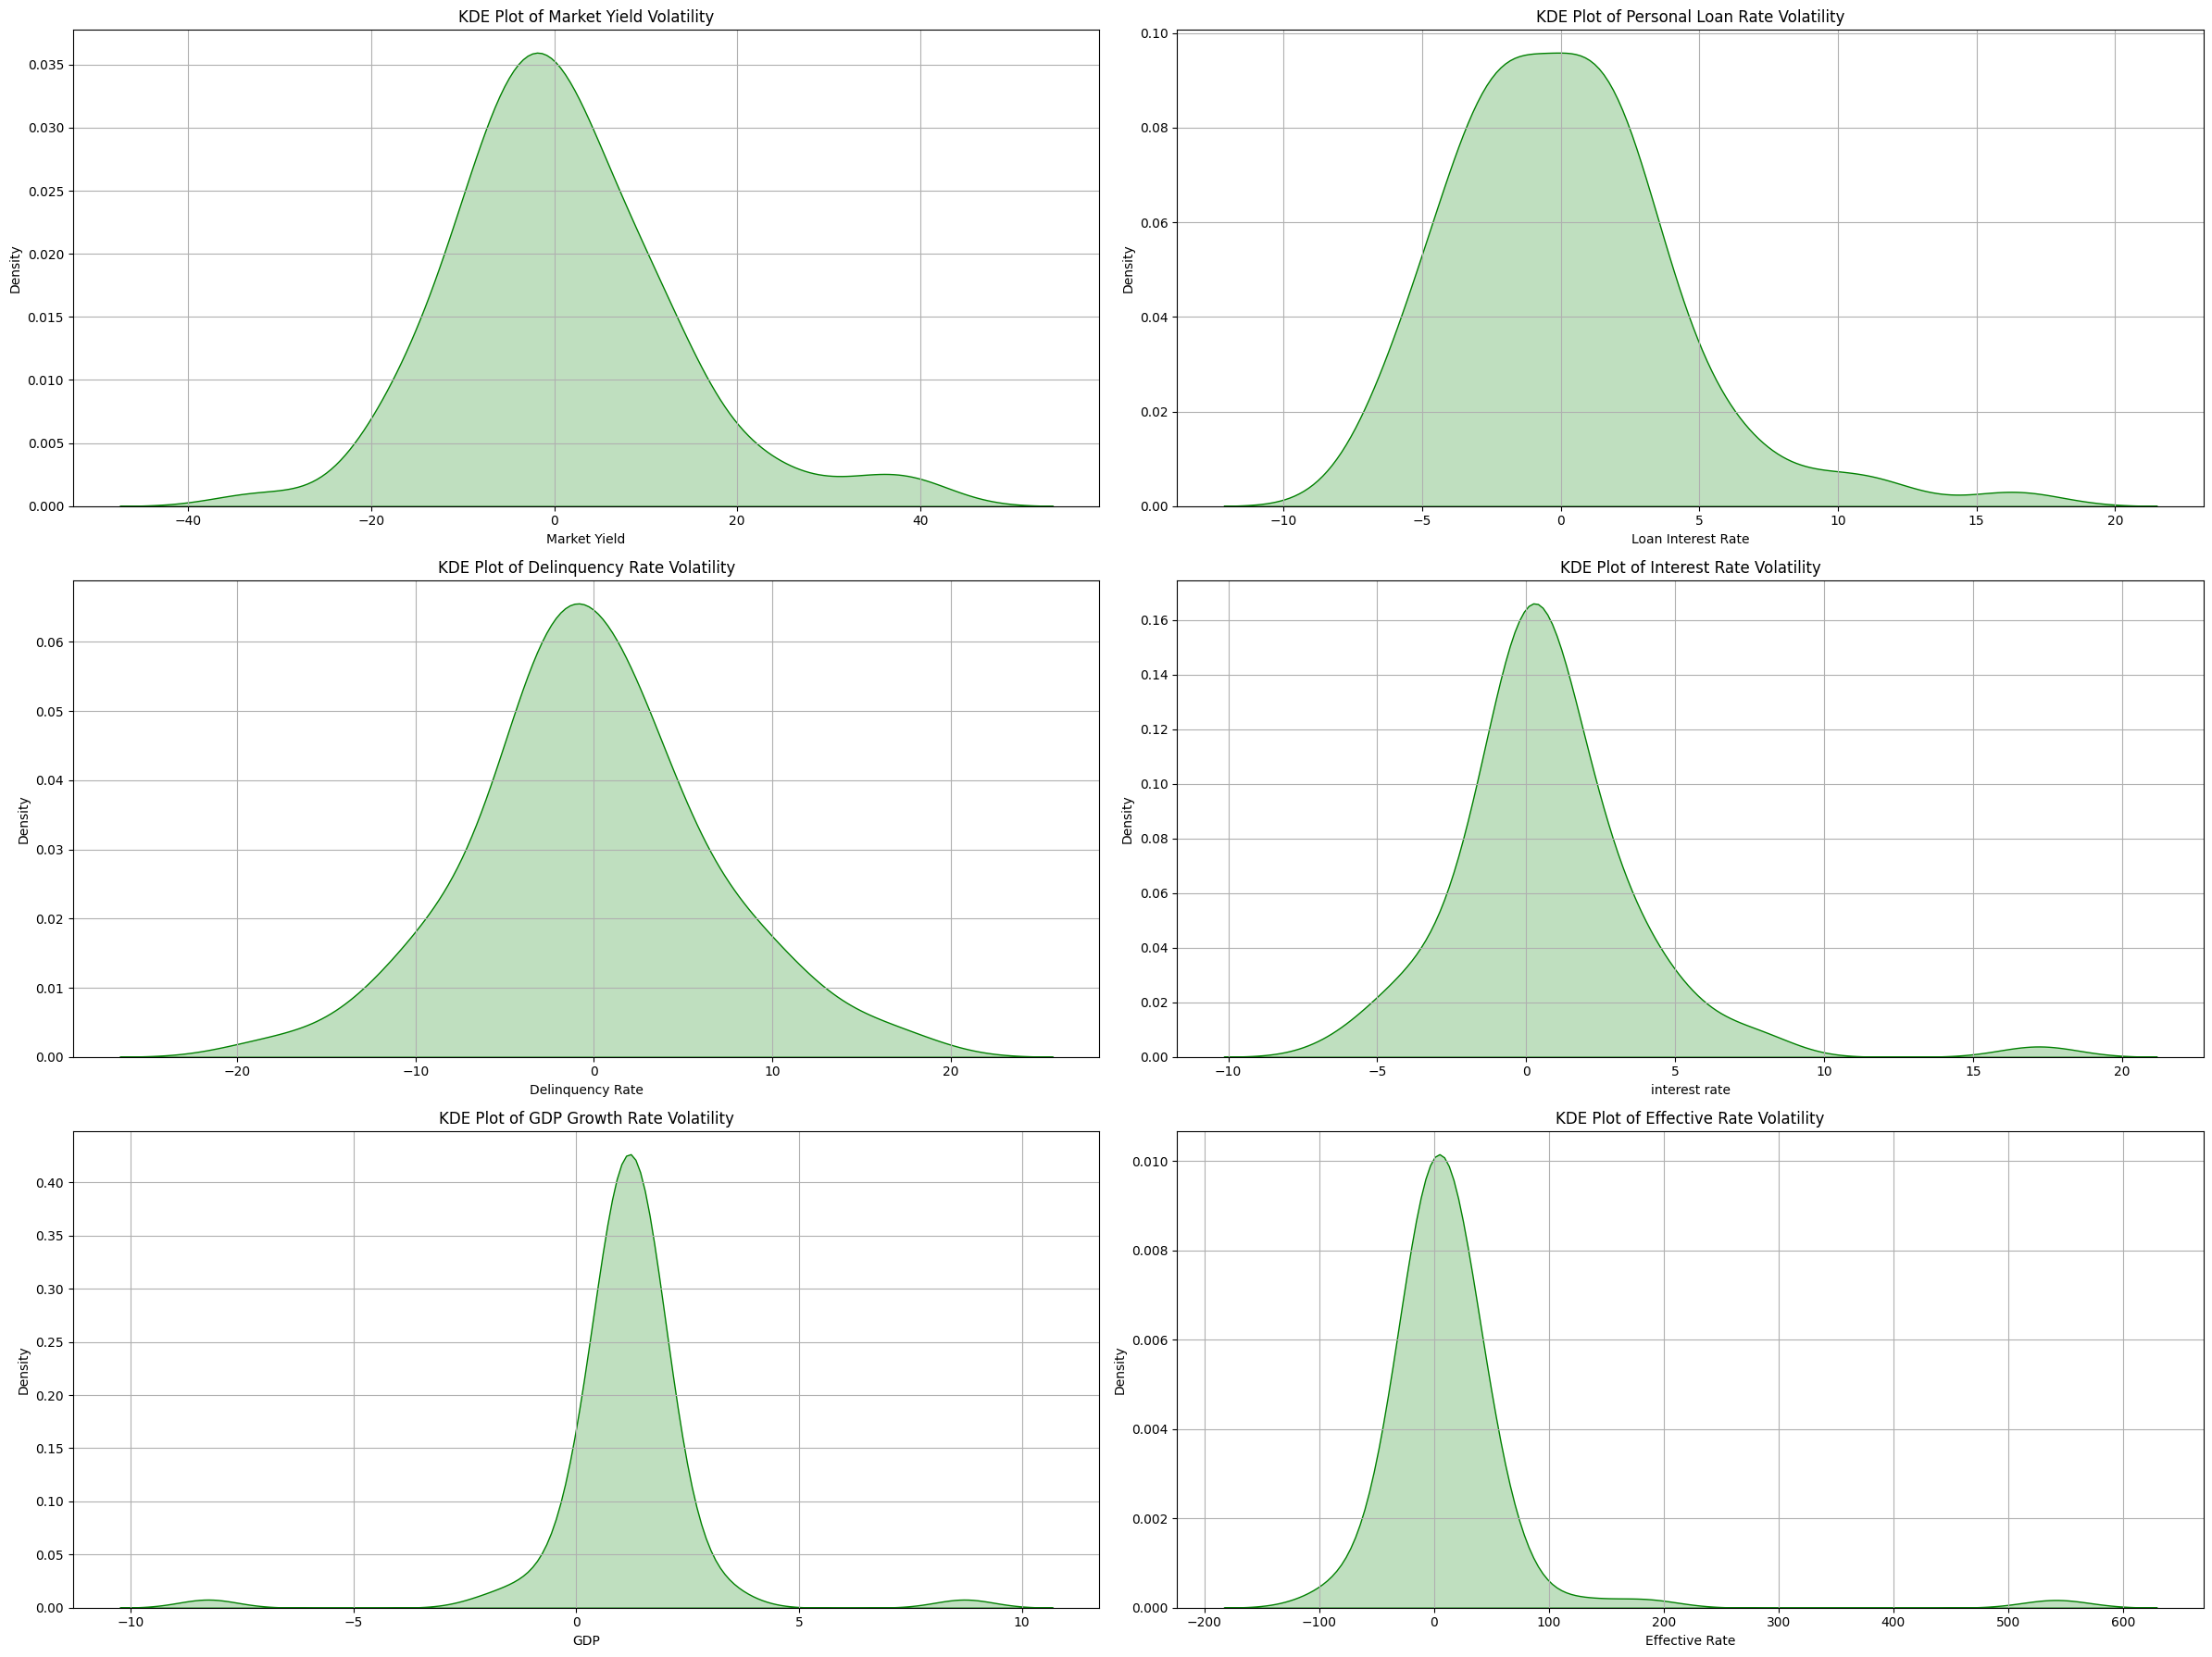

In [56]:
def plot_kde(*args):
    num_plots = len(args) // 3
    num_rows = (num_plots + 1) // 2

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(24, 6 * num_rows))

    for i in range(num_plots):
        df = args[i * 3]
        title = args[i * 3 + 1]
        col = args[i * 3 + 2]

        row = i // 2
        col_pos = i % 2

        sns.kdeplot(df[col], color='green', fill=True, ax=axes[row, col_pos])
        axes[row, col_pos].set_title(title)
        axes[row, col_pos].set_xlabel(col)
        axes[row, col_pos].set_ylabel('Density')
        axes[row, col_pos].grid(True)

    plt.tight_layout()
    plt.show()

volatility_df = volatility(market_yield_df, personal_loan_rate_df, delinquency_rate_df, interest_rate_df, gdp_rate_df, effective_rate_df)

market_yield_title = 'KDE Plot of Market Yield Volatility'
personal_loan_rate_title = 'KDE Plot of Personal Loan Rate Volatility'
delinquency_rate_title = 'KDE Plot of Delinquency Rate Volatility'
interest_rate_title = 'KDE Plot of Interest Rate Volatility'
gdp_rate_title = 'KDE Plot of GDP Growth Rate Volatility'
effective_rate_title = 'KDE Plot of Effective Rate Volatility'

plot_kde(
    volatility_df, market_yield_title, 'Market Yield',
    volatility_df, personal_loan_rate_title, 'Loan Interest Rate',
    volatility_df, delinquency_rate_title, 'Delinquency Rate',
    volatility_df, interest_rate_title, 'interest rate',
    volatility_df, gdp_rate_title, 'GDP',
    volatility_df, effective_rate_title, 'Effective Rate'
)

In this script, we are creating a correlation heatmap to show the relationships between the volatilities of various economic indicators. The heatmap displays the correlation coefficients between each pair of indicators, helping us understand how closely related their volatilities are. This visualization makes it easy to see which indicators move together and which ones do not.

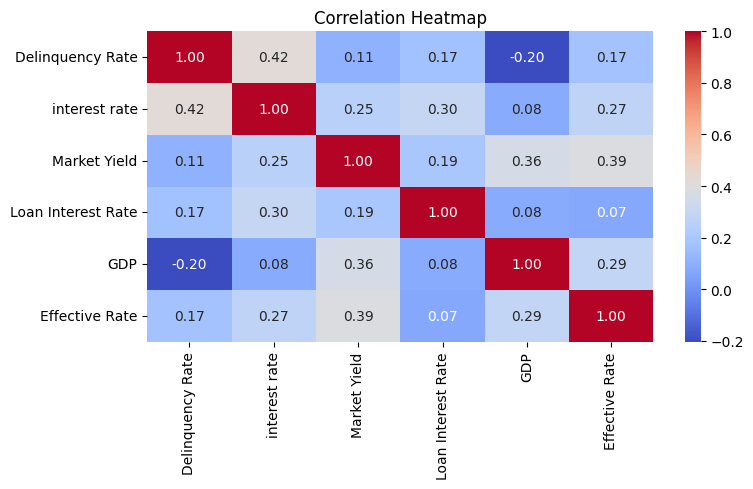

In [57]:
def corr(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(8, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

vol = volatility(delinquency_rate_df, interest_rate_df, market_yield_df, personal_loan_rate_df, gdp_rate_df, effective_rate_df)
corr(vol)

In [58]:
vol.describe().T

count       mean        std        min        25%  \
Delinquency Rate     79.0  -0.181663   6.556284 -18.367347  -3.729011   
interest rate        79.0   0.717489   3.170589  -6.181015  -0.779619   
Market Yield         79.0   0.692021  12.300713 -32.119514  -6.453294   
Loan Interest Rate   79.0   0.129726   4.100288  -7.028754  -2.586773   
GDP                  79.0   1.096992   1.584946  -8.261898   0.798064   
Effective Rate       79.0  14.250041  70.219369 -95.238095 -10.565476   

                         50%        75%         max  
Delinquency Rate   -0.401606   3.483340   17.500000  
interest rate       0.480110   1.765722   17.209588  
Market Yield       -0.340066   6.577345   39.119619  
Loan Interest Rate -0.103627   2.036106   16.380298  
GDP                 1.216938   1.526692    8.710313  
Effective Rate      5.410822  19.604688  541.666667

In this script, we calculated the correlations between the volatilities of various macroeconomic indicators and credit-related data using the Pearson correlation coefficient. We also checked the statistical significance of these correlations with p-values. The results showed that the correlation between Market Yield and Loan Interest Rate is 0.19, which is not statistically significant (p-value = 0.0905). Similarly, the correlation between Market Yield and Delinquency Rate is 0.11 (p-value = 0.3493), also not significant. However, the correlation between Market Yield and Interest Rate is 0.25 and statistically significant (p-value = 0.0265), indicating a meaningful relationship. For GDP, none of the correlations with Loan Interest Rate (0.08), Delinquency Rate (-0.20), or Interest Rate (0.08) were significant, with p-values of 0.4906, 0.0714, and 0.4829 respectively. The Effective Rate showed no significant correlation with Loan Interest Rate (0.07, p-value = 0.5391) or Delinquency Rate (0.17, p-value = 0.1273), but it did show a significant correlation with Interest Rate (0.27, p-value = 0.0153). These results suggest that while some economic factors like Market Yield and Effective Rate have significant relationships with credit-related metrics like Interest Rate, others do not show strong or significant connections. This analysis helps us understand the interactions between economic indicators and credit metrics, highlighting areas of significant influence.

In [59]:
from scipy.stats import pearsonr

macro_data = ['Market Yield', 'GDP', 'Effective Rate']
credit_data = ['Loan Interest Rate', 'Delinquency Rate', 'interest rate']
volatility_df = volatility(delinquency_rate_df, interest_rate_df, market_yield_df, personal_loan_rate_df, gdp_rate_df, effective_rate_df)

def calculate_correlations(volatility_df, data1, data2):
    correlations = {}
    p_values = {}

    for data1_col in data1:
        correlations[data1_col] = {}
        p_values[data1_col] = {}
        for data2_col in data2:
            corr, p_value = pearsonr(volatility_df[data1_col], volatility_df[data2_col])
            correlations[data1_col][data2_col] = corr
            p_values[data1_col][data2_col] = p_value

            print(f"{data1_col} vs {data2_col}: Correlation = {corr:.2f}, P-value = {p_value:.4f}")
            
            if p_value < 0.05:
                print("   The correlation is statistically significant.")
            else:
                print("   The correlation is not statistically significant.")
    
    return correlations, p_values

correlations, p_values = calculate_correlations(volatility_df, macro_data, credit_data)


Market Yield vs Loan Interest Rate: Correlation = 0.19, P-value = 0.0905
   The correlation is not statistically significant.
Market Yield vs Delinquency Rate: Correlation = 0.11, P-value = 0.3493
   The correlation is not statistically significant.
Market Yield vs interest rate: Correlation = 0.25, P-value = 0.0265
   The correlation is statistically significant.
GDP vs Loan Interest Rate: Correlation = 0.08, P-value = 0.4906
   The correlation is not statistically significant.
GDP vs Delinquency Rate: Correlation = -0.20, P-value = 0.0714
   The correlation is not statistically significant.
GDP vs interest rate: Correlation = 0.08, P-value = 0.4829
   The correlation is not statistically significant.
Effective Rate vs Loan Interest Rate: Correlation = 0.07, P-value = 0.5391
   The correlation is not statistically significant.
Effective Rate vs Delinquency Rate: Correlation = 0.17, P-value = 0.1273
   The correlation is not statistically significant.
Effective Rate vs interest rate: C

In this script, we use pair plot a valuable tool for preliminary data analysis, allowing us to quickly assess potential correlations and the overall structure of the data. This visualization aids in understanding how different macroeconomic indicators and credit metrics interact with each other.

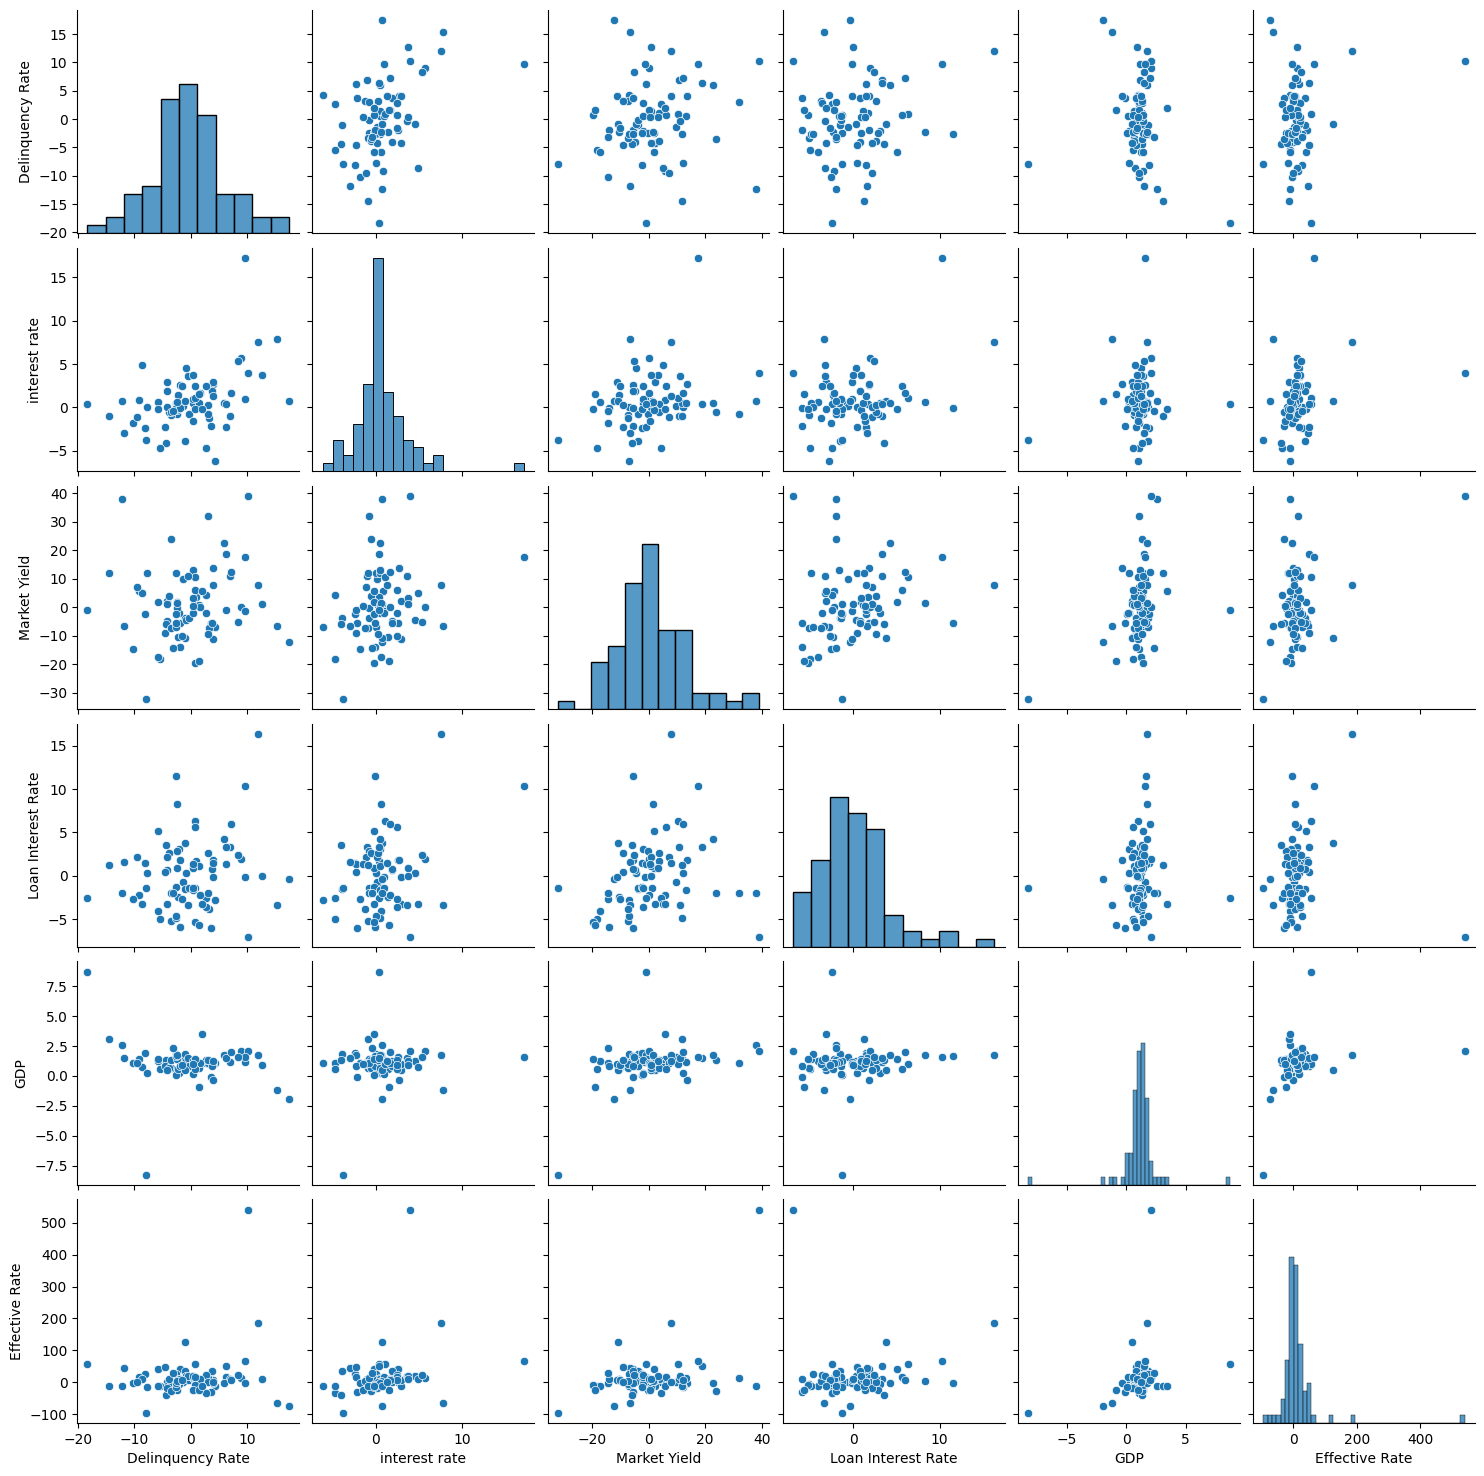

In [60]:
sns.pairplot(volatility_df)

In this script, we performed the Augmented Dickey-Fuller (ADF) test on the volatility data to check if each series is stationary. Stationarity is important because it means the statistical properties of the series do not change over time, which is crucial for granger casuality test  analysis methods.

In [61]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

volatility_df = volatility(delinquency_rate_df, interest_rate_df, market_yield_df, personal_loan_rate_df, gdp_rate_df, effective_rate_df)

def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF statistics for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] <= 0.05:
        print(f"{column_name} is stationary")
        print('')
        return True
    else:
        print(f"{column_name} is not stationary")
        print('')
        return False
    print('')

def make_stationary(df):
    stationary_df = pd.DataFrame()
    for column in df.columns:
        series = df[column]
        is_stationary = adf_test(series, column)
        differencing_count = 0
        while not is_stationary:
            series = series.diff().dropna()
            differencing_count += 1
            is_stationary = adf_test(series, column)
            if differencing_count > 2: 
                break
        stationary_df[column] = series
    return stationary_df

stationary_volatility_df = make_stationary(volatility_df)

ADF statistics for Delinquency Rate: -4.779812005023137
p-value for Delinquency Rate: 5.943415936862519e-05
Critical Value 1%: -3.517113604831504
Critical Value 5%: -2.8993754262546574
Critical Value 10%: -2.5869547797501644
Delinquency Rate is stationary

ADF statistics for interest rate: -4.394580117861085
p-value for interest rate: 0.0003034575211701177
Critical Value 1%: -3.5219803175527606
Critical Value 5%: -2.9014701097664504
Critical Value 10%: -2.58807215485756
interest rate is stationary

ADF statistics for Market Yield: -6.025436335607989
p-value for Market Yield: 1.4597643884033348e-07
Critical Value 1%: -3.518281134660583
Critical Value 5%: -2.899878185191432
Critical Value 10%: -2.5872229937594873
Market Yield is stationary

ADF statistics for Loan Interest Rate: -10.672882362816258
p-value for Loan Interest Rate: 4.1238444317242905e-19
Critical Value 1%: -3.517113604831504
Critical Value 5%: -2.8993754262546574
Critical Value 10%: -2.5869547797501644
Loan Interest Rate i

In this script, we conducted Granger causality tests to explore potential causal relationships between macroeconomic indicators and credit-related variables using volatility data. Granger causality tests help determine if past values of one variable (macroeconomic indicator) can help predict another variable (credit-related metric).

Granger causality helps us understand if changes in macroeconomic indicators can predict changes in credit-related variables. This insight is crucial for financial analysis and forecasting, providing evidence of potential causal links between economic factors and credit market behaviors.

In [62]:
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

macro_data = ['Market Yield', 'GDP', 'Effective Rate']
credit_data = ['Loan Interest Rate', 'Delinquency Rate', 'interest rate']
volatility_df = volatility(delinquency_rate_df, interest_rate_df, market_yield_df, personal_loan_rate_df, gdp_rate_df, effective_rate_df)

def granger_causality_report(data, macro_vars, credit_vars, max_lag):
    report = {}
    best_results = []

    for macro_var in macro_vars:
        for credit_var in credit_vars:
            p_values = []
            for lag in range(1, max_lag + 1):
                result = grangercausalitytests(data[[credit_var, macro_var]], lag, verbose=False)
                p_value = result[lag][0]['ssr_ftest'][1]
                p_values.append(p_value)
            
            min_p_value = min(p_values)
            best_lag = p_values.index(min_p_value) + 1
            report[f"{macro_var}->{credit_var}"] = p_values

            if min_p_value < 0.05:
                best_results.append((macro_var, credit_var, min_p_value, best_lag))

    return report, best_results

max_lag = 20
report, best_results = granger_causality_report(volatility_df, macro_data, credit_data, max_lag)

df_report = pd.DataFrame(report, index=[f"Lag {lag}" for lag in range(1, max_lag + 1)])
df_report = df_report.transpose()

df_report.head(10)

Lag 1         Lag 2         Lag 3  \
Market Yield->Loan Interest Rate    0.000741  3.794442e-03  6.324827e-03   
Market Yield->Delinquency Rate      0.589909  7.071062e-01  8.040144e-01   
Market Yield->interest rate         0.132641  2.674930e-01  3.048144e-01   
GDP->Loan Interest Rate             0.031107  9.286756e-02  1.445778e-01   
GDP->Delinquency Rate               0.000262  2.509346e-04  2.654934e-04   
GDP->interest rate                  0.946089  9.769726e-01  9.932813e-01   
Effective Rate->Loan Interest Rate  0.000001  5.687922e-08  1.543790e-07   
Effective Rate->Delinquency Rate    0.020551  8.035126e-02  9.117843e-02   
Effective Rate->interest rate       0.004906  8.650323e-07  1.740654e-06   

                                           Lag 4         Lag 5     Lag 6  \
Market Yield->Loan Interest Rate    5.550060e-03  1.492798e-02  0.006217   
Market Yield->Delinquency Rate      3.184609e-01  3.778092e-01  0.413947   
Market Yield->interest rate         4.410351e-01  5.243919e-01  0.403560   
GDP->Loan Interest Rate             2.897777e-01  4.089644e-01  0.107418   
GDP->Delinquency Rate               4.903459e-05  1.811121e-05  0.000036   
GDP->interest rate                  7.632692e-01  6.866810e-01  0.581964   
Effective Rate->Loan Interest Rate  3.450249e-07  5.947344e-07  0.000003   
Effective Rate->Delinquency Rate    1.189255e-01  2.417342e-01  0.397930   
Effective Rate->interest rate       4.963962e-06  8.141887e-06  0.000023   

                                       Lag 7     Lag 8     Lag 9    Lag 10  \
Market Yield->Loan Interest Rate    0.003333  0.001297  0.002889  0.002154   
Market Yield->Delinquency Rate      0.544547  0.580713  0.620180  0.714069   
Market Yield->interest rate         0.032980  0.067772  0.168656  0.395801   
GDP->Loan Interest Rate             0.173502  0.007776  0.011005  0.008715   
GDP->Delinquency Rate               0.000014  0.000016  0.000033  0.000100   
GDP->interest rate                  0.529669  0.697104  0.407855  0.004389   
Effective Rate->Loan Interest Rate  0.000004  0.000003  0.000002  0.000012   
Effective Rate->Delinquency Rate    0.321560  0.345363  0.426336  0.479118   
Effective Rate->interest rate       0.000063  0.000146  0.000278  0.001891   

                                      Lag 11    Lag 12    Lag 13    Lag 14  \
Market Yield->Loan Interest Rate    0.005318  0.029680  0.022272  0.039904   
Market Yield->Delinquency Rate      0.768546  0.703551  0.670863  0.674973   
Market Yield->interest rate         0.411160  0.408736  0.445028  0.567298   
GDP->Loan Interest Rate             0.013590  0.001917  0.005801  0.018974   
GDP->Delinquency Rate               0.000072  0.000166  0.000094  0.000346   
GDP->interest rate                  0.009634  0.006610  0.014245  0.010772   
Effective Rate->Loan Interest Rate  0.000040  0.000242  0.000472  0.001030   
Effective Rate->Delinquency Rate    0.366841  0.300847  0.218988  0.386028   
Effective Rate->interest rate       0.005691  0.014346  0.033429  0.034316   

                                      Lag 15    Lag 16    Lag 17    Lag 18  \
Market Yield->Loan Interest Rate    0.035193  0.028722  0.019767  0.007803   
Market Yield->Delinquency Rate      0.806141  0.642047  0.469447  0.327022   
Market Yield->interest rate         0.295545  0.446885  0.564780  0.702921   
GDP->Loan Interest Rate             0.030669  0.029207  0.071964  0.232670   
GDP->Delinquency Rate               0.000787  0.000730  0.002172  0.004353   
GDP->interest rate                  0.000539  0.001950  0.001896  0.003220   
Effective Rate->Loan Interest Rate  0.001754  0.006049  0.016554  0.041036   
Effective Rate->Delinquency Rate    0.350821  0.371478  0.486899  0.592196   
Effective Rate->interest rate       0.006088  0.014548  0.028711  0.038319   

                                      Lag 19    Lag 20  
Market Yield->Loan Interest Rate    0.014142  0.021839  
Market Yield->Delinquency Rate      0.126421  0.169730  
Mar

These findings highlight how fluctuations in macroeconomic factors such as Market Yield, GDP, and Effective Rate can predict changes in credit-related variables like Loan Interest Rates, Delinquency Rates, and general interest rates over different time periods. Understanding these causal relationships is crucial for the financing team in making informed decisions and predictions about economic trends and financial stability.

In [63]:
best_results_df = pd.DataFrame(best_results, columns=['Macro Variable', 'Credit Variable', 'Min P-Value', 'Best Lag'])
best_results_df

Macro Variable     Credit Variable   Min P-Value  Best Lag
0    Market Yield  Loan Interest Rate  7.409808e-04         1
1    Market Yield       interest rate  3.297976e-02         7
2             GDP  Loan Interest Rate  1.917359e-03        12
3             GDP    Delinquency Rate  1.372966e-05         7
4             GDP       interest rate  5.387477e-04        15
5  Effective Rate  Loan Interest Rate  5.687922e-08         2
6  Effective Rate    Delinquency Rate  2.055089e-02         1
7  Effective Rate       interest rate  8.650323e-07         2

<h1>Scenario 2 - Money at a fixed rate for a business for a construction loan

<h7>In this analysis, we will look at how different economic factors are connected to contruction debt. We want to see how things like GDP growth, Unemployment Rate, Commercial Real Estate Loans, and delinquency rates on business loan affect each other. This will help us understand how these factors influence construction debt metrics and the risk of constructio company not being able to pay back their debts.

We will use data from reliable sources like the Federal Reserve Economic Data (FRED) and other financial databases. With Python, we will bring in this data, create visualizations, and analyze it. We will make graphs to show changes over time, how data is spread out, and how different factors are related.

Our main goal is to find out if changes in macro economic factors can cause changes in construction debt metrics. To do this, we will use a Granger causality test, which helps us understand if one thing can predict another.

In [64]:
UR_df = macroeconomic_datas('Money at a fixed rate for a business for a construction loan/Unemployment Rate.csv', 
                    ['Unemployment Rate'])

(32, 1)
           Unemployment Rate
DATE                        
1/1/2016            4.900000
4/1/2016            4.933333
7/1/2016            4.900000
10/1/2016           4.766667
1/1/2017            4.566667


In [65]:
RE_loans_df = macroeconomic_datas('Money at a fixed rate for a business for a construction loan/Real Estate Loans Commercial Real Estate Loans.csv',
                                 ['Price'])

(32, 1)
                Price
DATE                 
1/1/2016   268.074154
4/1/2016   277.993838
7/1/2016   286.938008
10/1/2016  296.147908
1/1/2017   305.390269


In [66]:
GDP_df = macroeconomic_datas('Money at a fixed rate for a business for a construction loan/GDP.csv',
                            ['GDP'])

(32, 1)
                 GDP
DATE                
1/1/2016   18525.933
4/1/2016   18711.702
7/1/2016   18892.639
10/1/2016  19089.379
1/1/2017   19280.084


In [67]:
delinquency_rate_df = macroeconomic_datas('Money at a fixed rate for a business for a construction loan/Delinquency Rate on Business Loans.csv',
                                         ['Delinquency Rate'])

(32, 1)
           Delinquency Rate
DATE                       
1/1/2016               1.50
4/1/2016               1.60
7/1/2016               1.59
10/1/2016              1.58
1/1/2017               1.53


In this script, we're creating graphs to visualize quarterly economic data for several key indicators. Each graph represents a different facet of the economy: the "Unemployment Rate quarterly data" graph tracks changes in joblessness, offering insights into employment trends. The "Real Estate Loans Commercial Real Estate Loans quarterly data" graph shows trends in loans for commercial properties, revealing investment patterns in real estate. The "GDP quarterly data" graph displays fluctuations in Gross Domestic Product, indicating economic growth over time. Lastly, the "Delinquency Rate on Business Loans quarterly data" graph illustrates how often businesses miss loan payments. These visualizations help us analyze economic trends and understand their impact across various sectors of the economy.

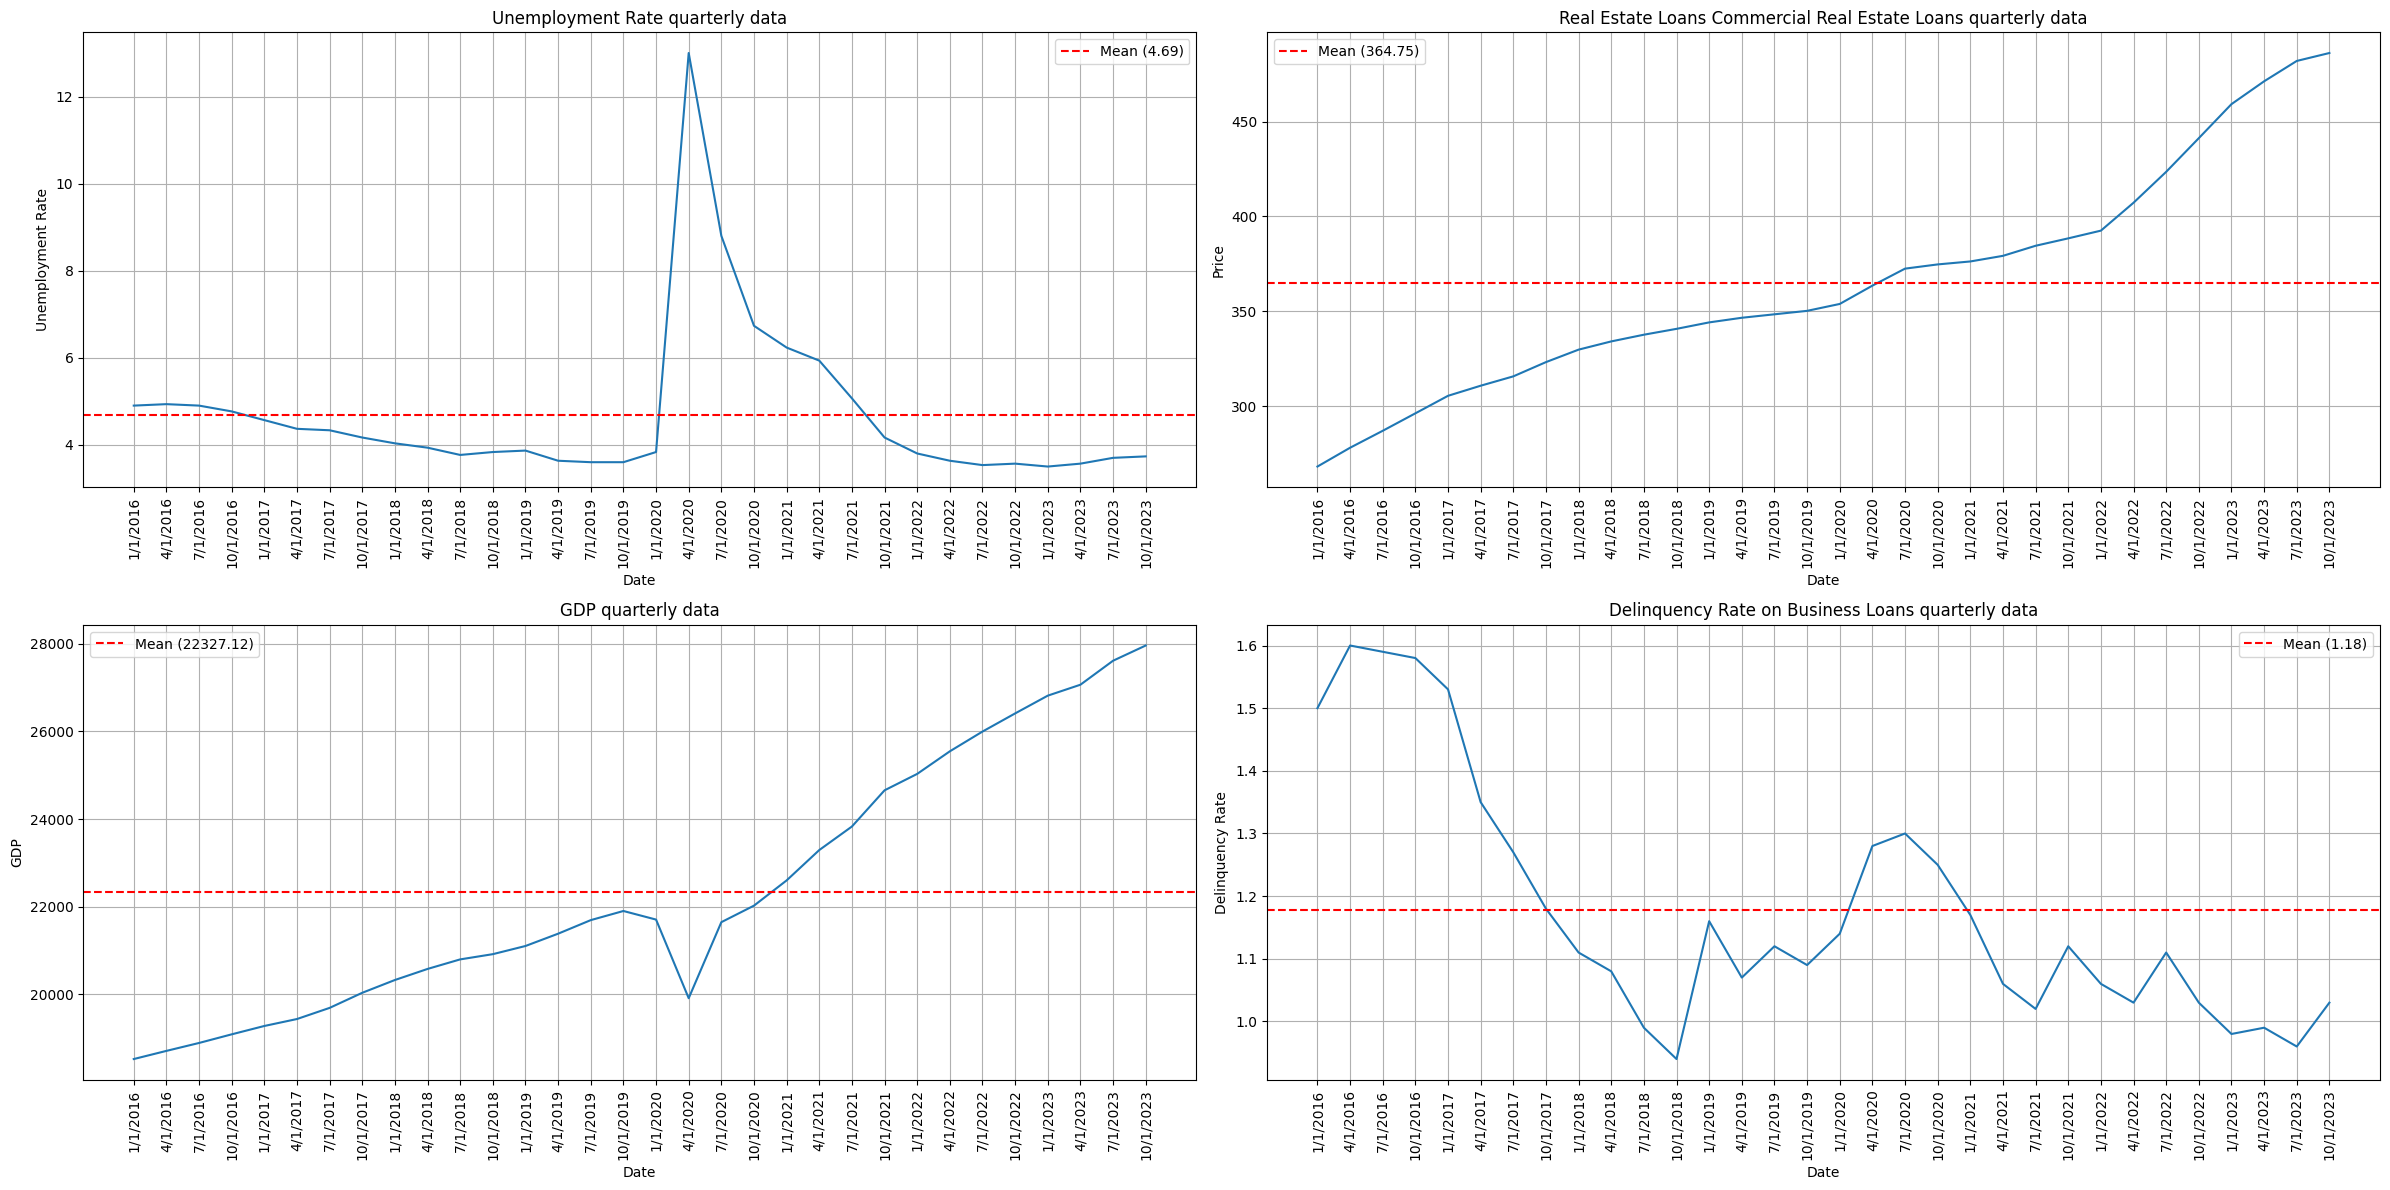

In [68]:
plot_economic_data(
    (UR_df, 'Unemployment Rate quarterly data'),
    (RE_loans_df, 'Real Estate Loans Commercial Real Estate Loans quarterly data'),
    (GDP_df, 'GDP quarterly data'),
    (delinquency_rate_df, 'Delinquency Rate on Business Loans quarterly data')
)

In [113]:
return_df = volatility(UR_df, RE_loans_df, GDP_df, delinquency_rate_df)
return_df.tail()

Unemployment Rate     Price       GDP  Delinquency Rate
DATE                                                              
8/1/2023            8.571429       NaN       NaN               NaN
9/1/2023            0.000000       NaN       NaN               NaN
10/1/2023           0.000000  0.868252  1.256314          7.291667
11/1/2023          -2.631579       NaN       NaN               NaN
12/1/2023           0.000000       NaN       NaN               NaN

In this script, we're putting our volatility function to plot the volatility of several economic indicators. We calculate the rolling standard deviation (volatility) for each dataset and standardize the results to make them comparable. Then, we plot these standardized volatilities on a single graph to show how they change over time.

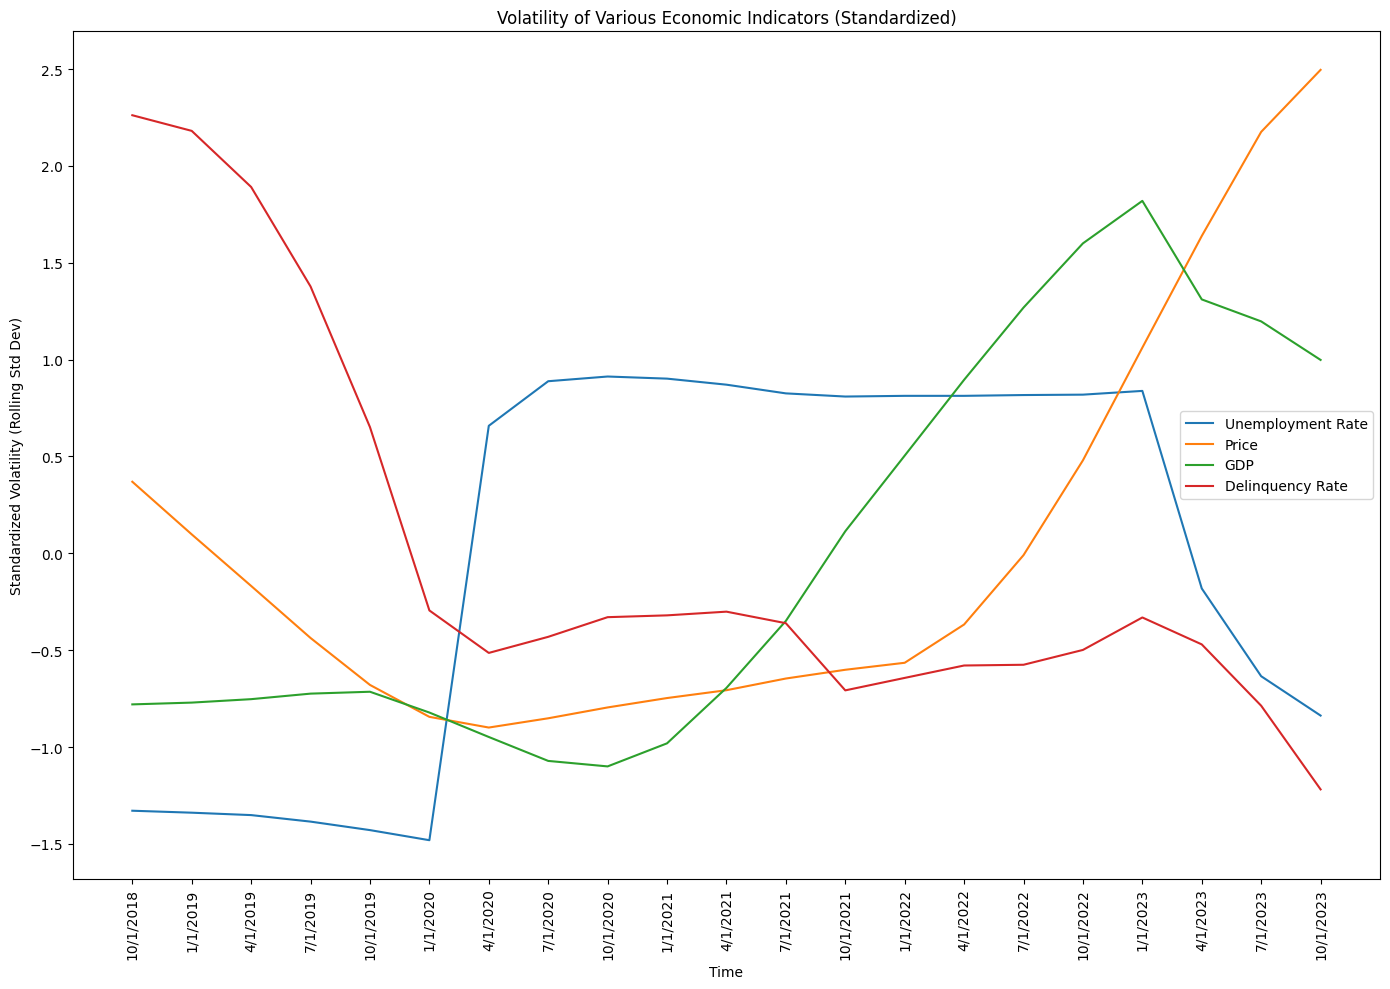

In [70]:
volatility_chart(UR_df, RE_loans_df, GDP_df, delinquency_rate_df)

In this script, we are creating histograms to check the distribution of volatility for several economic indicators. Each histogram shows how frequently different levels of volatility occur for indicators like delinquency rates on buisness loans, unemployement rates, GDP growth rate, and the commercial real estate loan. This helps us understand the variability and distribution of these economic factors over time.

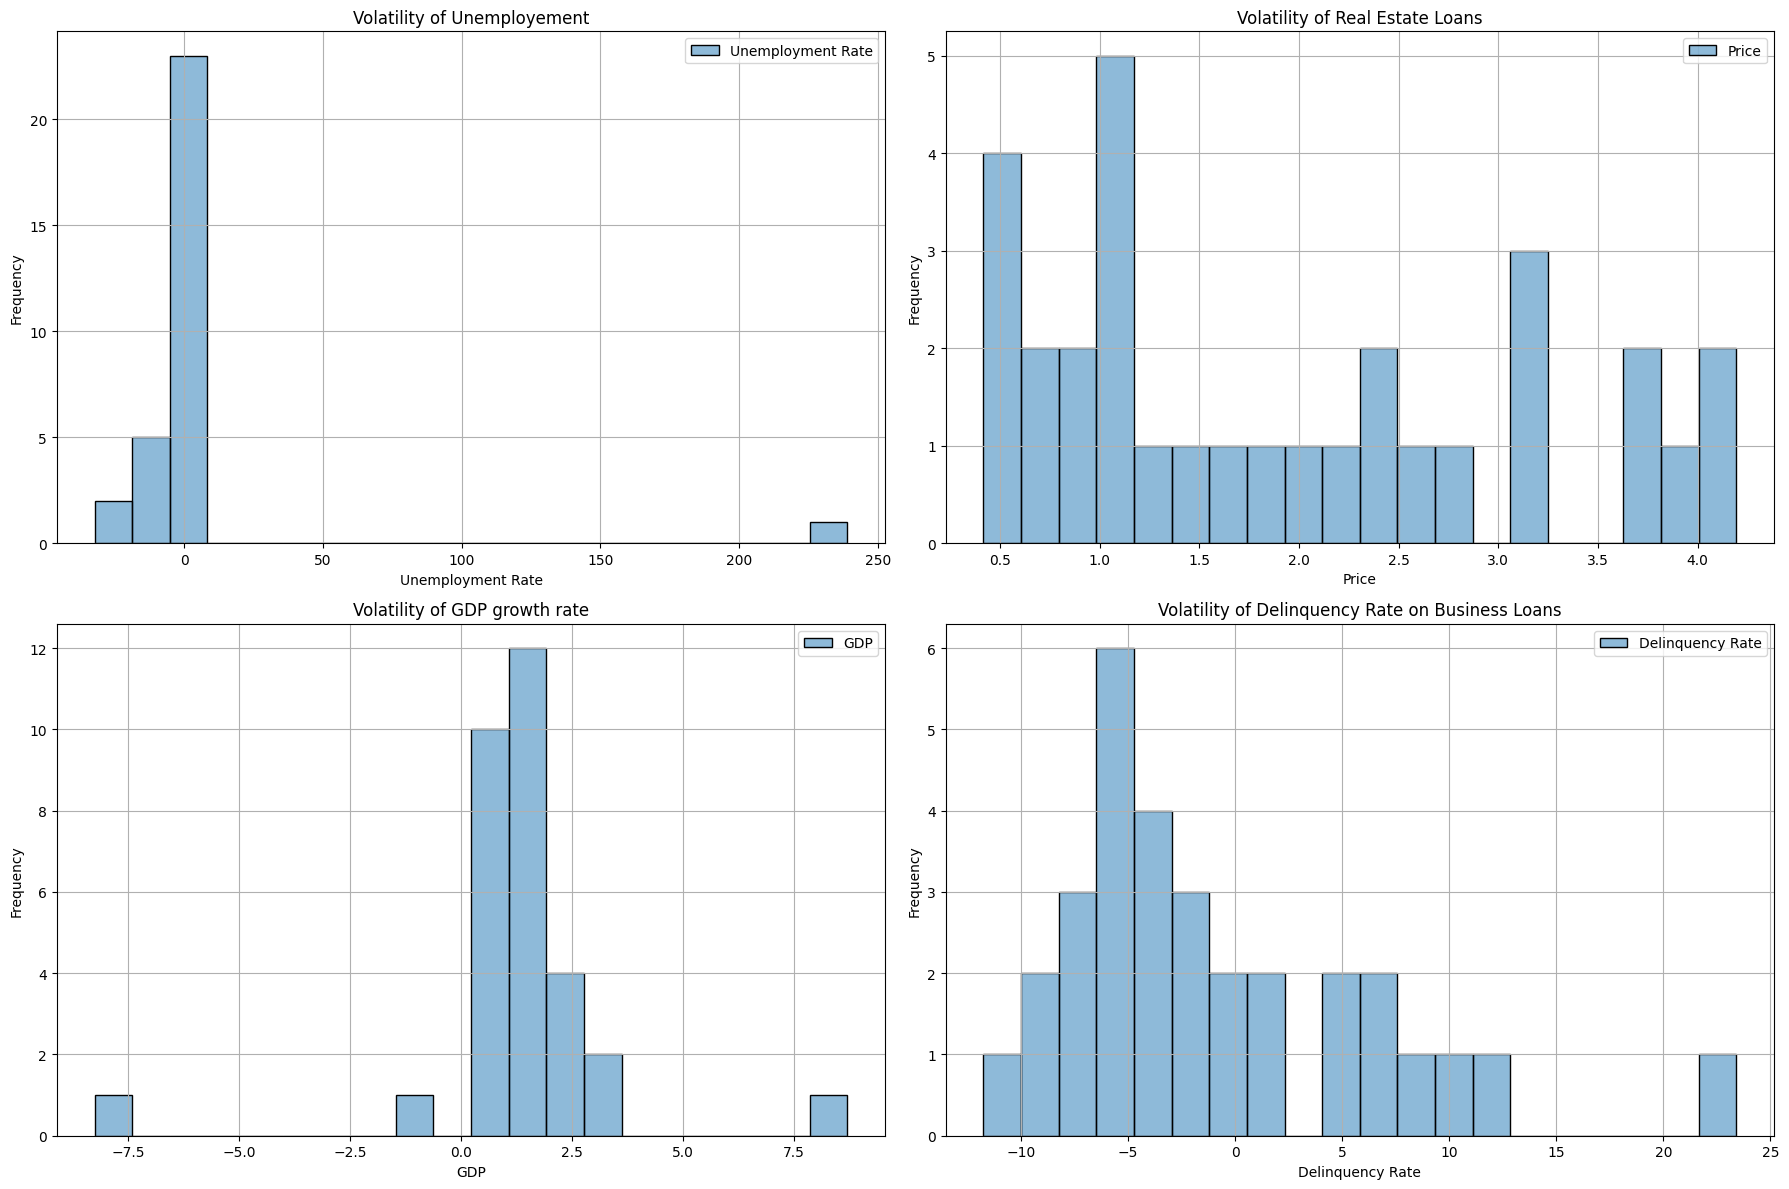

In [71]:
unemployement_title = 'Volatility of Unemployement'
RE_rate_title = 'Volatility of Real Estate Loans'
GDP_title = 'Volatility of GDP growth rate'
delinquency_rate_title = 'Volatility of Delinquency Rate on Business Loans'

plot_data = [
    (return_df[['Unemployment Rate']], unemployement_title),
    (return_df[['Price']], RE_rate_title),
    (return_df[['GDP']], GDP_title),
    (return_df[['Delinquency Rate']], delinquency_rate_title)
]
plot_economic_distributions(*plot_data)

In this script, we are creating KDE (Kernel Density Estimate) plots to visualize the distribution of volatility for several economic indicators. Each plot shows the density of volatility values, helping us understand the variability and concentration of different levels of volatility for indicators likedelinquency rates on buisness loans, unemployement rates, GDP growth rate, and the commercial real estate loan.

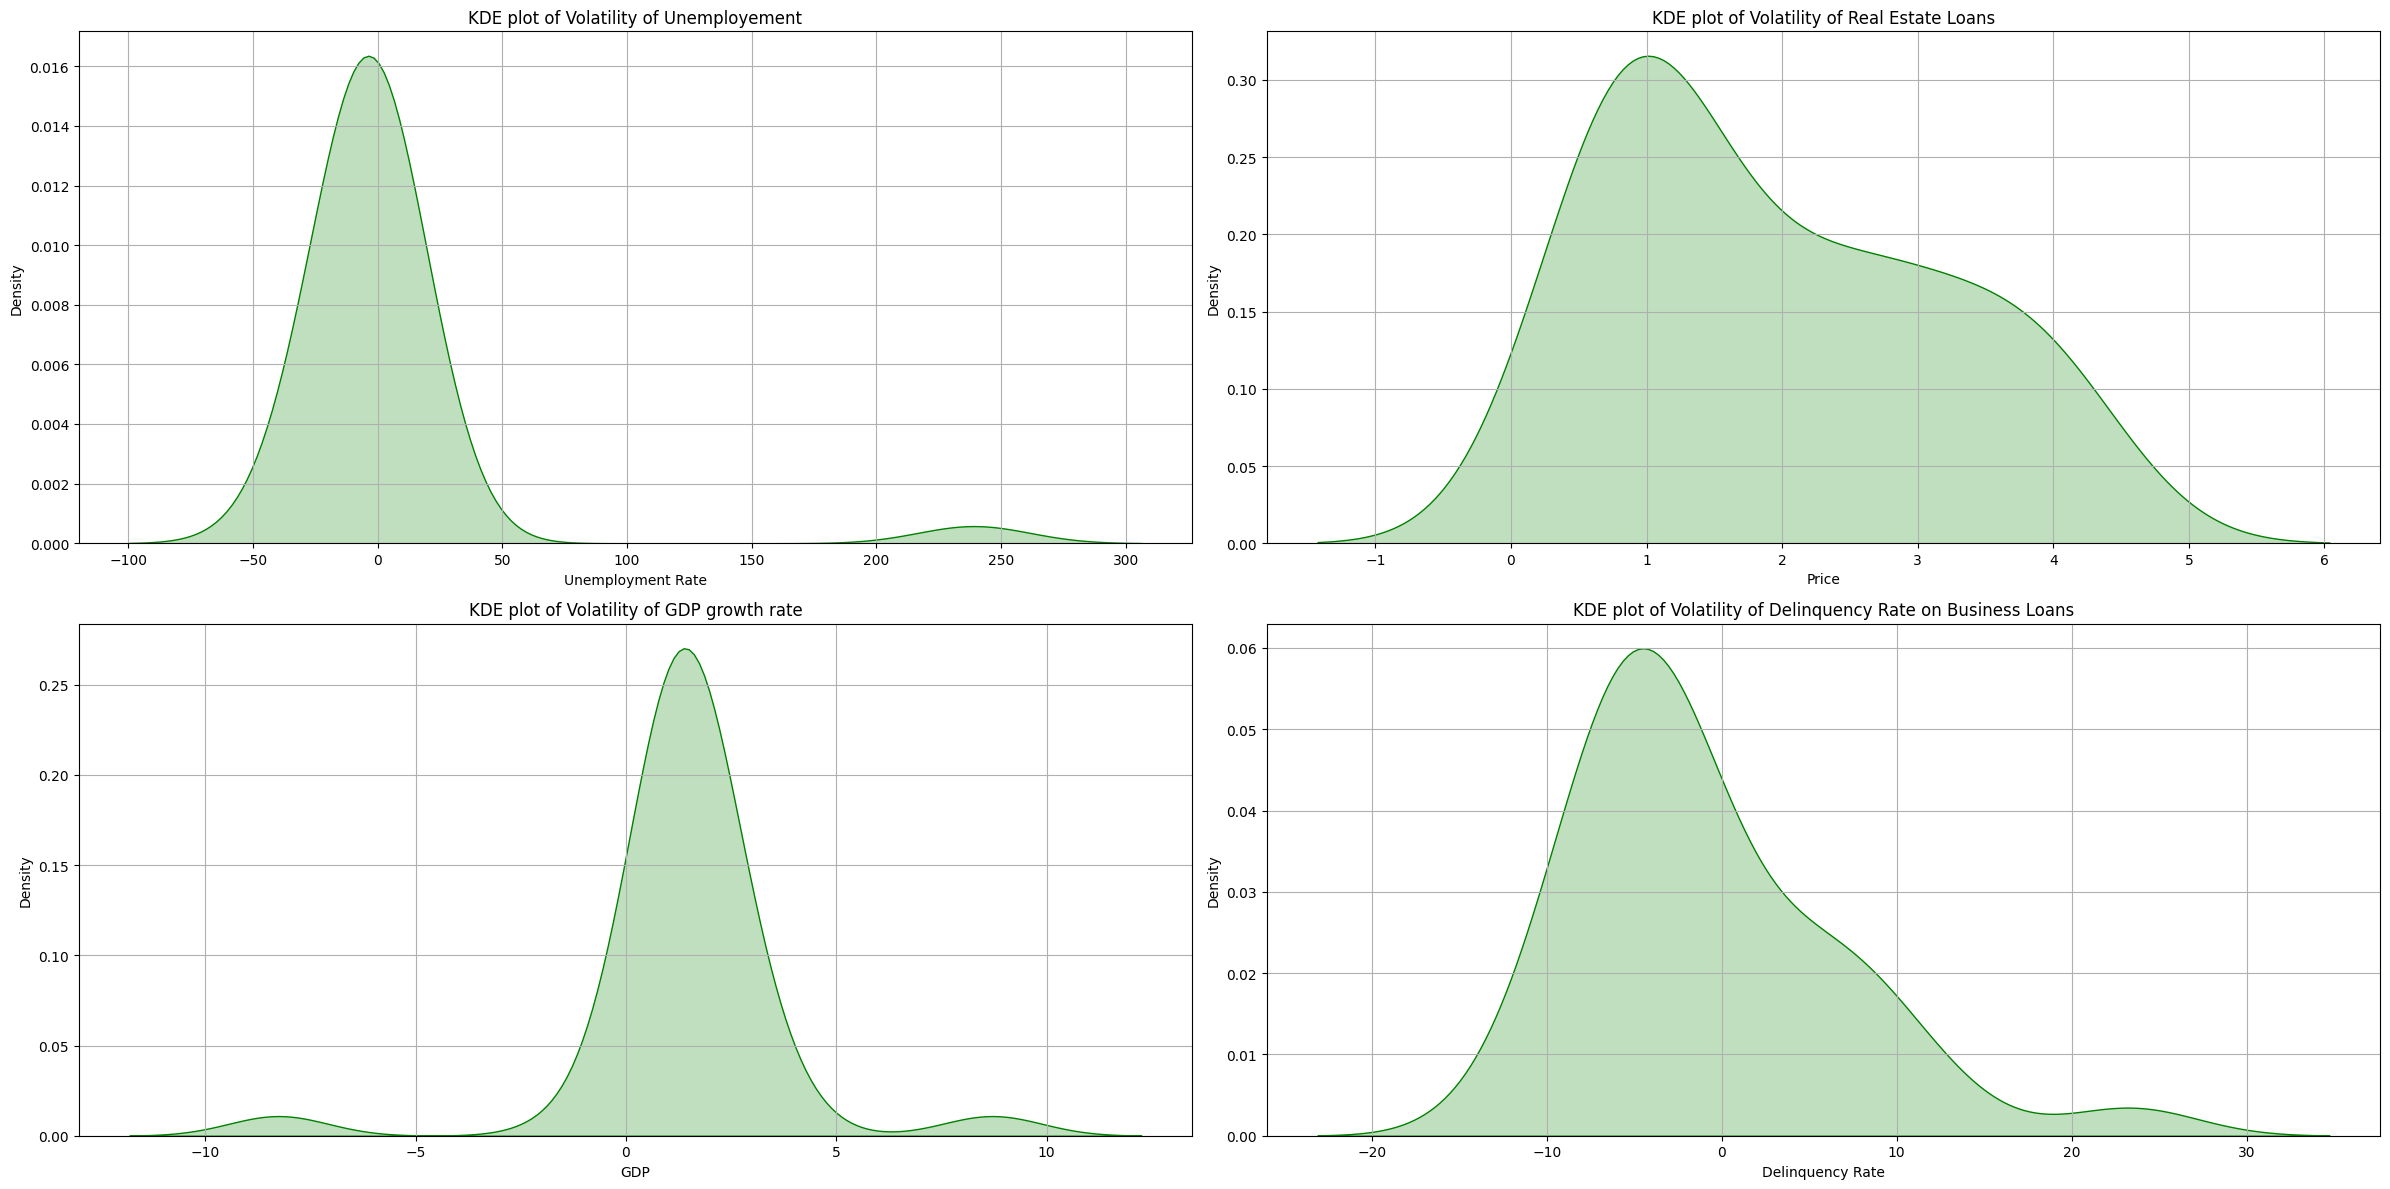

In [72]:
unemployement_title = 'KDE plot of Volatility of Unemployement'
RE_rate_title = 'KDE plot of Volatility of Real Estate Loans'
GDP_title = 'KDE plot of Volatility of GDP growth rate'
delinquency_rate_title = 'KDE plot of Volatility of Delinquency Rate on Business Loans'


plot_kde(
    return_df,unemployement_title, 'Unemployment Rate',
    return_df, RE_rate_title , 'Price',
    return_df, GDP_title, 'GDP',
    return_df, delinquency_rate_title, 'Delinquency Rate',
)

In this script, we are creating a correlation heatmap to show the relationships between the volatilities of various economic indicators. The heatmap displays the correlation coefficients between each pair of indicators, helping us understand how closely related their volatilities are. This visualization makes it easy to see which indicators move together and which ones do not.

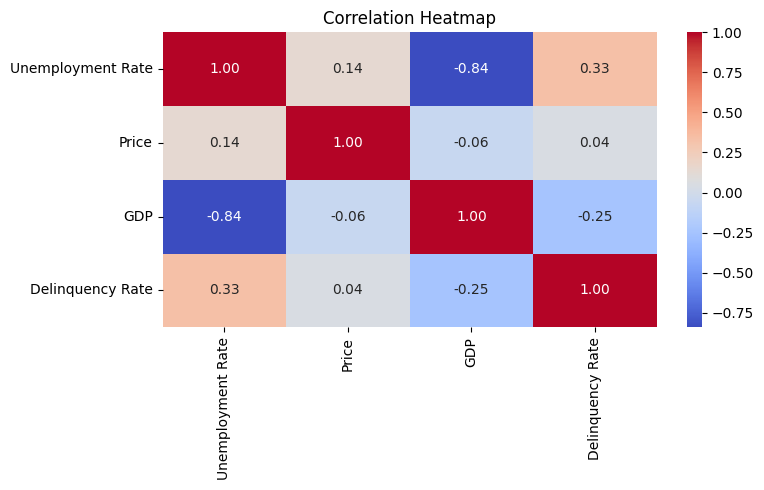

In [73]:
corr(return_df)

In [74]:
return_df.describe().T

count      mean        std        min       25%       50%  \
Unemployment Rate   31.0  3.379369  44.473546 -32.307692 -4.599400 -2.721088   
Price               31.0  1.946374   1.220538   0.416422  0.957715  1.587722   
GDP                 31.0  1.363129   2.345921  -8.261898  0.982992  1.329796   
Delinquency Rate    31.0 -0.945005   7.506568 -11.764706 -5.929065 -3.030303   

                        75%         max  
Unemployment Rate  0.774919  239.130435  
Price              2.924531    4.193822  
GDP                1.756217    8.710313  
Delinquency Rate   3.074828   23.404255

In [75]:
macro_data = ['GDP', 'Unemployment Rate']
loan_data = ['Delinquency Rate', 'Price']
correlations, p_values = calculate_correlations(return_df, macro_data, loan_data)

GDP vs Delinquency Rate: Correlation = -0.25, P-value = 0.1797
   The correlation is not statistically significant.
GDP vs Price: Correlation = -0.06, P-value = 0.7465
   The correlation is not statistically significant.
Unemployment Rate vs Delinquency Rate: Correlation = 0.33, P-value = 0.0672
   The correlation is not statistically significant.
Unemployment Rate vs Price: Correlation = 0.14, P-value = 0.4407
   The correlation is not statistically significant.


In this script, we use pair plot a valuable tool for preliminary data analysis, allowing us to quickly assess potential correlations and the overall structure of the data. This visualization aids in understanding how different macroeconomic indicators and credit metrics interact with each other.

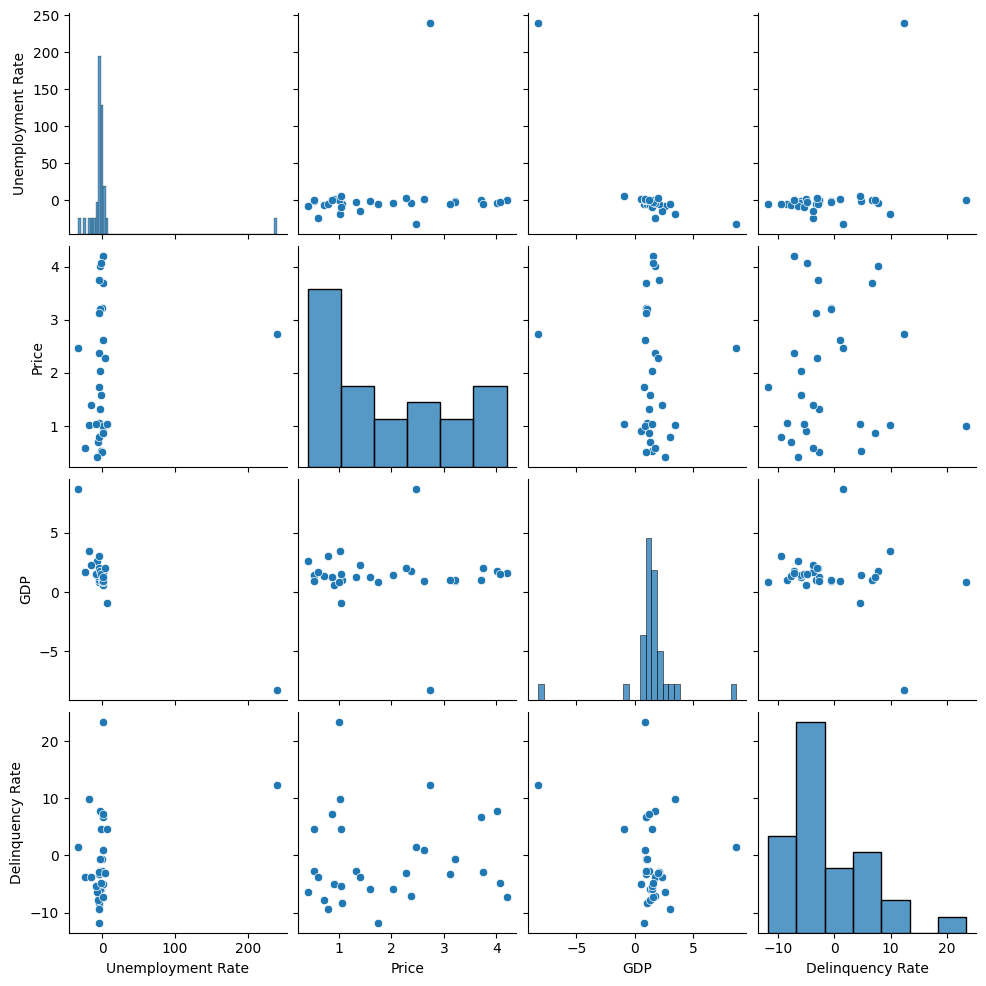

In [76]:
sns.pairplot(return_df)

In [77]:
stationary_volatility_df = make_stationary(return_df)

ADF statistics for Unemployment Rate: -5.7546009010606225
p-value for Unemployment Rate: 5.85932348700482e-07
Critical Value 1%: -3.6699197407407405
Critical Value 5%: -2.9640707407407407
Critical Value 10%: -2.621171111111111
Unemployment Rate is stationary

ADF statistics for Price: -1.935141373613994
p-value for Price: 0.3157142967295129
Critical Value 1%: -3.7377092158564813
Critical Value 5%: -2.9922162731481485
Critical Value 10%: -2.635746736111111
Price is not stationary

ADF statistics for Price: -1.4923338851348753
p-value for Price: 0.5373001901847906
Critical Value 1%: -3.8092091249999998
Critical Value 5%: -3.0216450000000004
Critical Value 10%: -2.6507125
Price is not stationary

ADF statistics for Price: -3.304058593253663
p-value for Price: 0.014698027134987409
Critical Value 1%: -3.8326031418574136
Critical Value 5%: -3.0312271701414204
Critical Value 10%: -2.655519584487535
Price is stationary

ADF statistics for GDP: -6.668941570576548
p-value for GDP: 4.640444163265

In this script, we conducted Granger causality tests to explore potential causal relationships between macroeconomic indicators and construction loan variables using volatility data. Granger causality tests help determine if past values of one variable (macroeconomic indicator) can help predict another variable (commercial construction debt related metric).

Granger causality helps us understand if changes in macroeconomic indicators can predict changes in construction debt-related variables. This insight is crucial for the financing team to analysis, forecast, and provide evidence of potential causal links between economic factors and construction debt market behaviors.

In [78]:
max_lag = 9
report, best_results = granger_causality_report(return_df, macro_data, loan_data, max_lag)

df_report = pd.DataFrame(report, index=[f"Lag {lag}" for lag in range(1, max_lag + 1)])
df_report = df_report.transpose()

df_report.head(10)

Lag 1     Lag 2     Lag 3     Lag 4  \
GDP->Delinquency Rate                0.293051  0.497406  0.719403  0.764155   
GDP->Price                           0.150172  0.104067  0.143722  0.113606   
Unemployment Rate->Delinquency Rate  0.472460  0.781787  0.838736  0.782698   
Unemployment Rate->Price             0.729055  0.084167  0.178666  0.197020   

                                        Lag 5     Lag 6     Lag 7     Lag 8  \
GDP->Delinquency Rate                0.474277  0.481505  0.556568  0.737973   
GDP->Price                           0.241059  0.391764  0.049359  0.087384   
Unemployment Rate->Delinquency Rate  0.696499  0.486571  0.642772  0.859383   
Unemployment Rate->Price             0.258410  0.218529  0.276494  0.096006   

                                        Lag 9  
GDP->Delinquency Rate                0.736489  
GDP->Price                           0.315476  
Unemployment Rate->Delinquency Rate  0.450779  
Unemployment Rate->Price             0.304516

In [79]:
best_results_df = pd.DataFrame(best_results, columns=['Macro Variable', 'Rate Variable', 'Min P-Value', 'Best Lag'])
best_results_df

Macro Variable Rate Variable  Min P-Value  Best Lag
0            GDP         Price     0.049359         7

<h2>Scenario 3 - Publicly Traded Equity 

In this analysis, we will look at how different economic factors are connected to publicly traded equity market. We want to see how things like GDP growth, Unemployment Rate, Consumer Price Index, and SnP 500 retruns overt time affect each other. This will help us understand how these factors influence the SnP 500 and the risk of default if the value of the S&P500 ETF decreases due to macro economic influence.

We will use data from reliable sources like the Federal Reserve Economic Data (FRED) and other financial databases. With Python, we will bring in this data, create visualizations, and analyze it. We will make graphs to show changes over time, how data is spread out, and how different factors are related.

Our main goal is to find out if changes in macro economic factors can cause change in S&P500 ETF market. To do this, we will use a Granger causality test, which helps us understand if one thing can predict another.

In [80]:
UR_df = macroeconomic_datas('Publicly traded equity/Unemployment Rate.csv', 
                    ['Unemployment Rate'])

(240, 1)
          Unemployment Rate
DATE                       
1/1/2004                5.7
2/1/2004                5.6
3/1/2004                5.8
4/1/2004                5.6
5/1/2004                5.6


In [81]:
CPI_df = macroeconomic_datas("Publicly traded equity/Consumer Price Index for All Urban Consumers.csv", ['CPI'])

(240, 1)
            CPI
DATE           
1/1/2004  186.3
2/1/2004  186.7
3/1/2004  187.1
4/1/2004  187.4
5/1/2004  188.2


In [82]:
SnP_df = macroeconomic_datas("Publicly traded equity/S&P 500 Historical Data.csv", ['SnP'])

(240, 1)
             SnP
DATE            
1/1/2004  1131.1
2/1/2004  1144.9
3/1/2004  1126.2
4/1/2004  1107.3
5/1/2004  1120.7


In [83]:
gdp_df = macroeconomic_datas("Publicly traded equity/GDP.csv", ['GDP_return'])

(80, 1)
           GDP_return
DATE                 
1/1/2004    11923.447
4/1/2004    12112.815
7/1/2004    12305.307
10/1/2004   12527.214
1/1/2005    12767.286


In this script, we're putting a function to plot multiple economic datasets on separate graphs. Each plot shows a different economic indicator over time, with a red dashed line marking the average value for that indicator. After defining the function, we use it to visualize data like, Unemployement rate, consumer price index, S&P 500 close price, and GDP growth rate from 2004 to 2023.

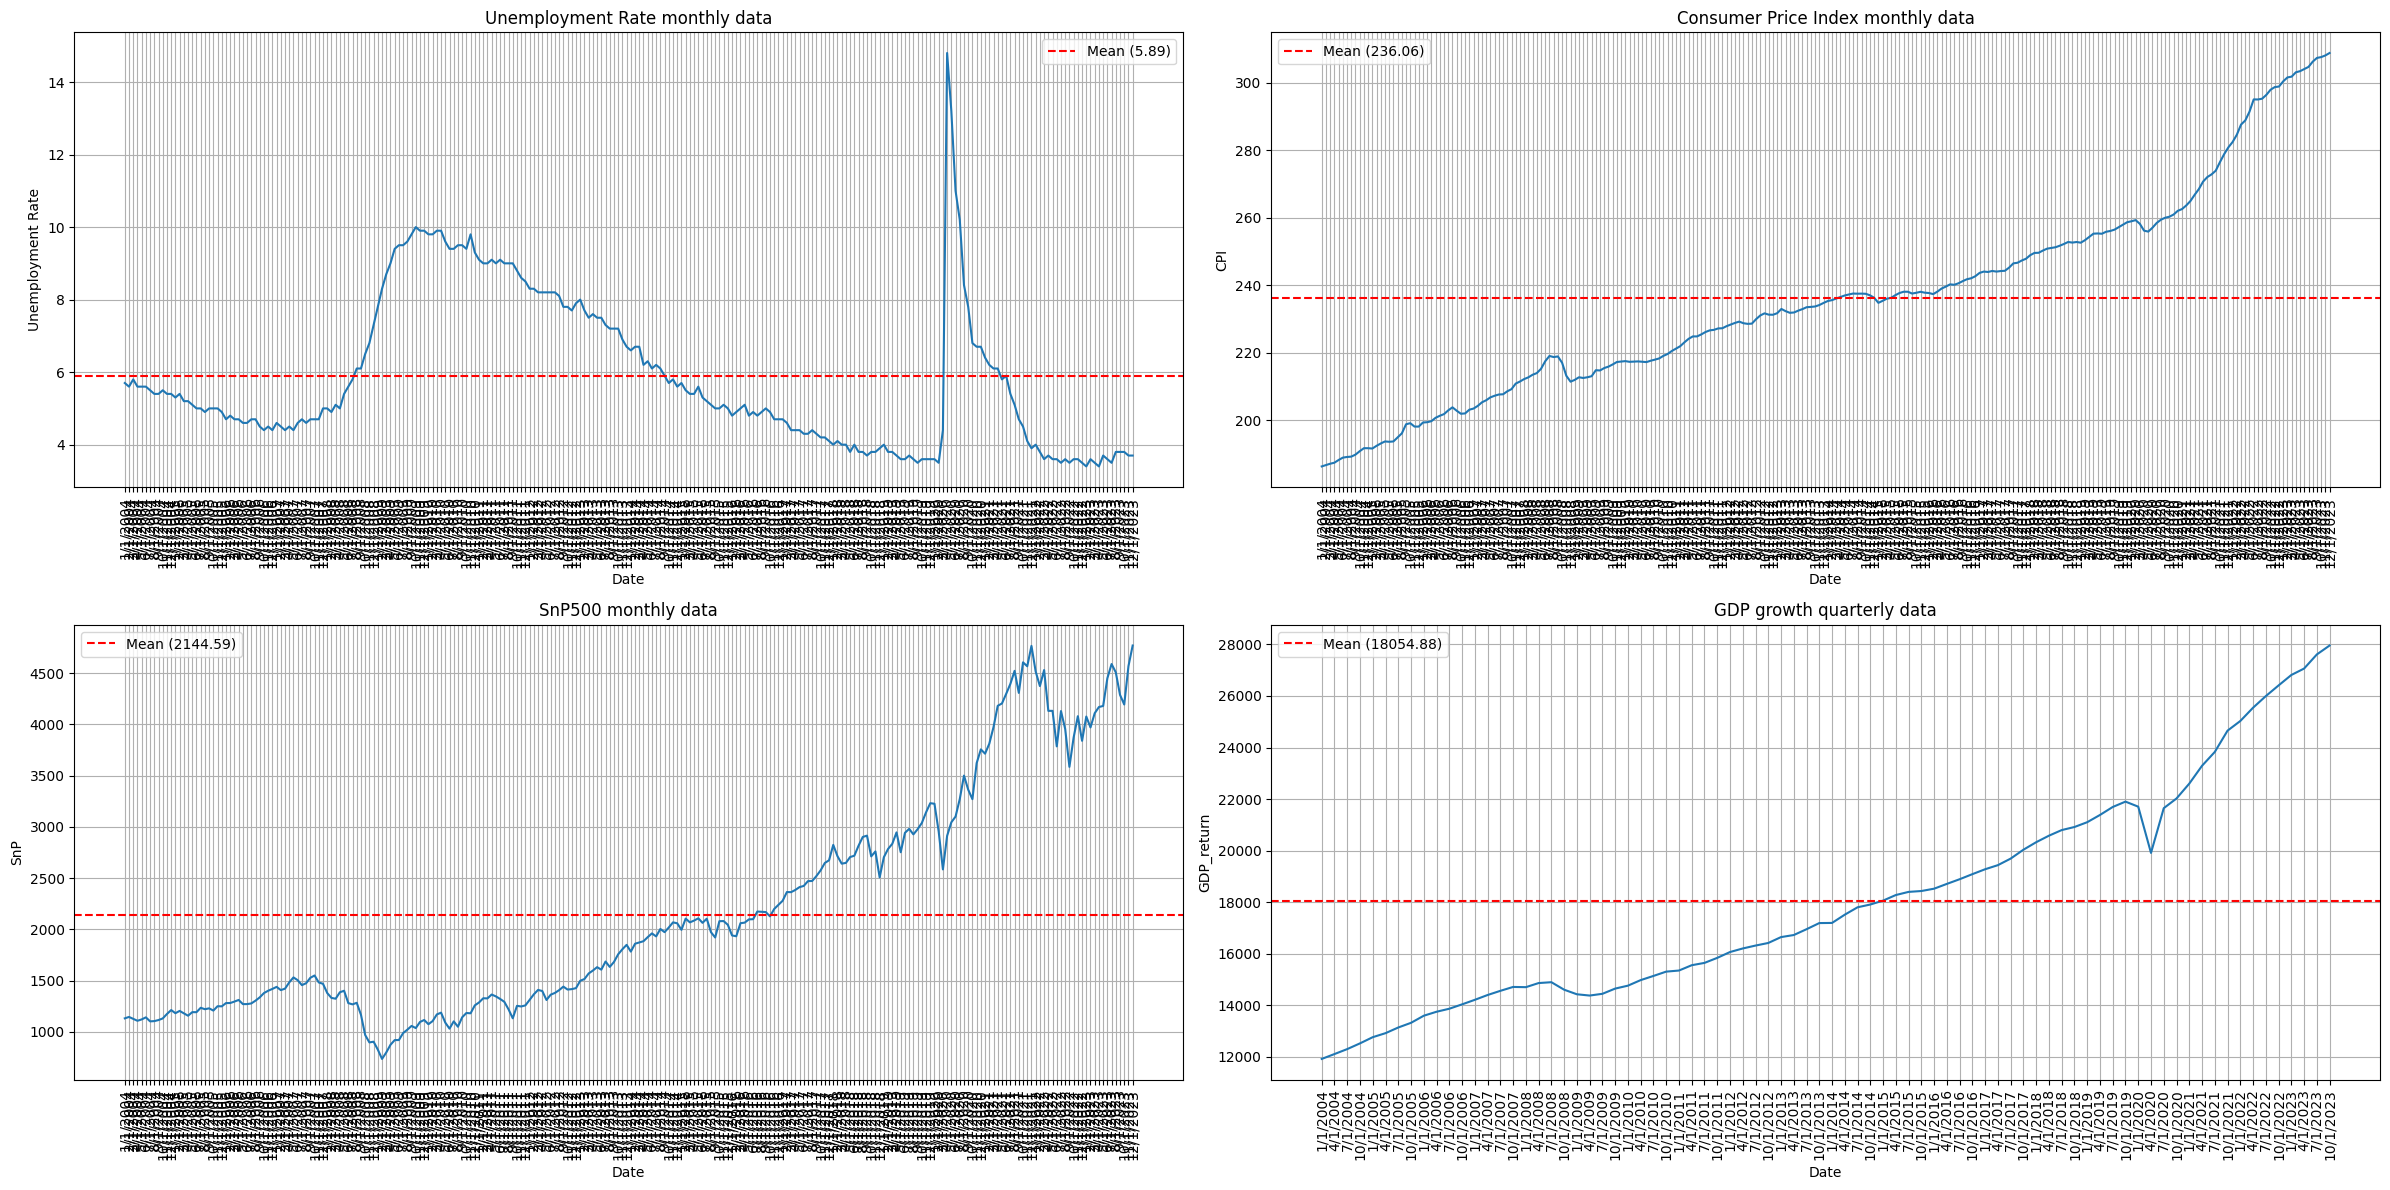

In [84]:
plot_economic_data(
    (UR_df, 'Unemployment Rate monthly data'),
    (CPI_df, 'Consumer Price Index monthly data'),
    (SnP_df, 'SnP500 monthly data'),
    (gdp_df, 'GDP growth quarterly data')
)

In [85]:
return_df = volatility(UR_df, CPI_df, SnP_df, gdp_df)
return_df.head()

Unemployment Rate       CPI       SnP  GDP_return
DATE                                                       
2/1/2004          -1.754386  0.214707  1.220051         NaN
3/1/2004           3.571429  0.214247 -1.633330         NaN
4/1/2004          -3.448276  0.160342 -1.678210    1.588198
5/1/2004           0.000000  0.426894  1.210151         NaN
6/1/2004           0.000000  0.371945  1.793522         NaN

In [86]:
return_df['GDP_return'] = return_df['GDP_return'].interpolate(method='linear', limit_direction='both')
return_df.head()

Unemployment Rate       CPI       SnP  GDP_return
DATE                                                       
2/1/2004          -1.754386  0.214707  1.220051    1.588198
3/1/2004           3.571429  0.214247 -1.633330    1.588198
4/1/2004          -3.448276  0.160342 -1.678210    1.588198
5/1/2004           0.000000  0.426894  1.210151    1.588519
6/1/2004           0.000000  0.371945  1.793522    1.588839

In this script, we're putting our volatility function to plot the volatility of several economic indicators and S&P 500 returns. We calculate the rolling standard deviation (volatility) for each dataset and standardize the results to make them comparable. Then, we plot these standardized volatilities on a single graph to show how they change over time.

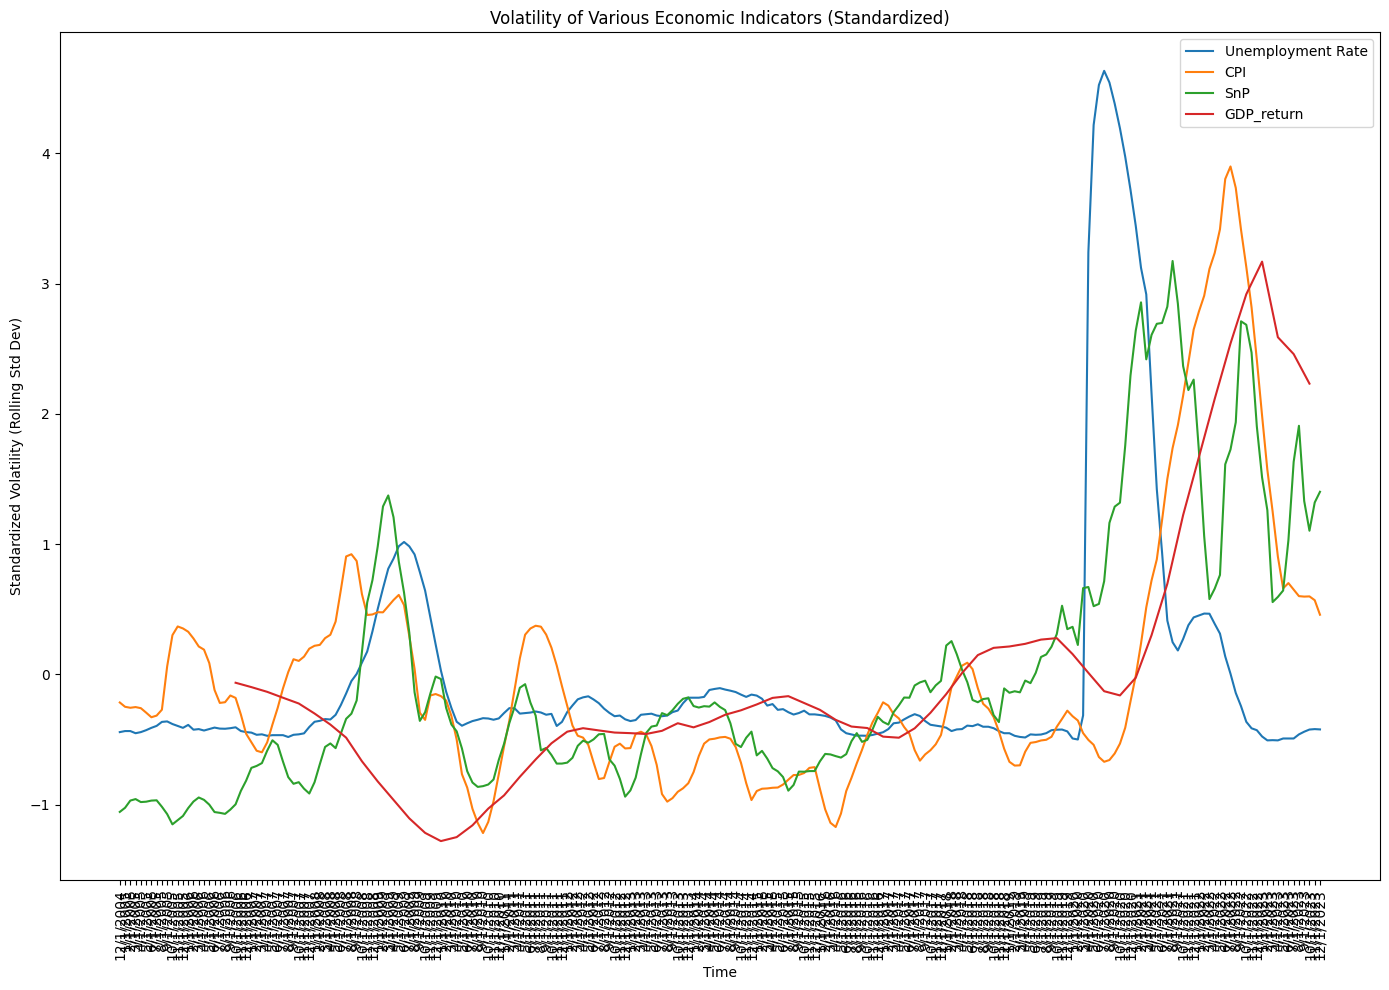

In [87]:
volatility_chart(UR_df, CPI_df, SnP_df, gdp_df)

In this script, we are creating histograms to check the distribution of volatility for several economic indicators. Each histogram shows how frequently different levels of volatility occur for indicators like  Unemployement rate, consumer price index, S&P 500 close price, and GDP growth rate. This helps us understand the variability and distribution of these economic factors and S&P 500 returns over time.

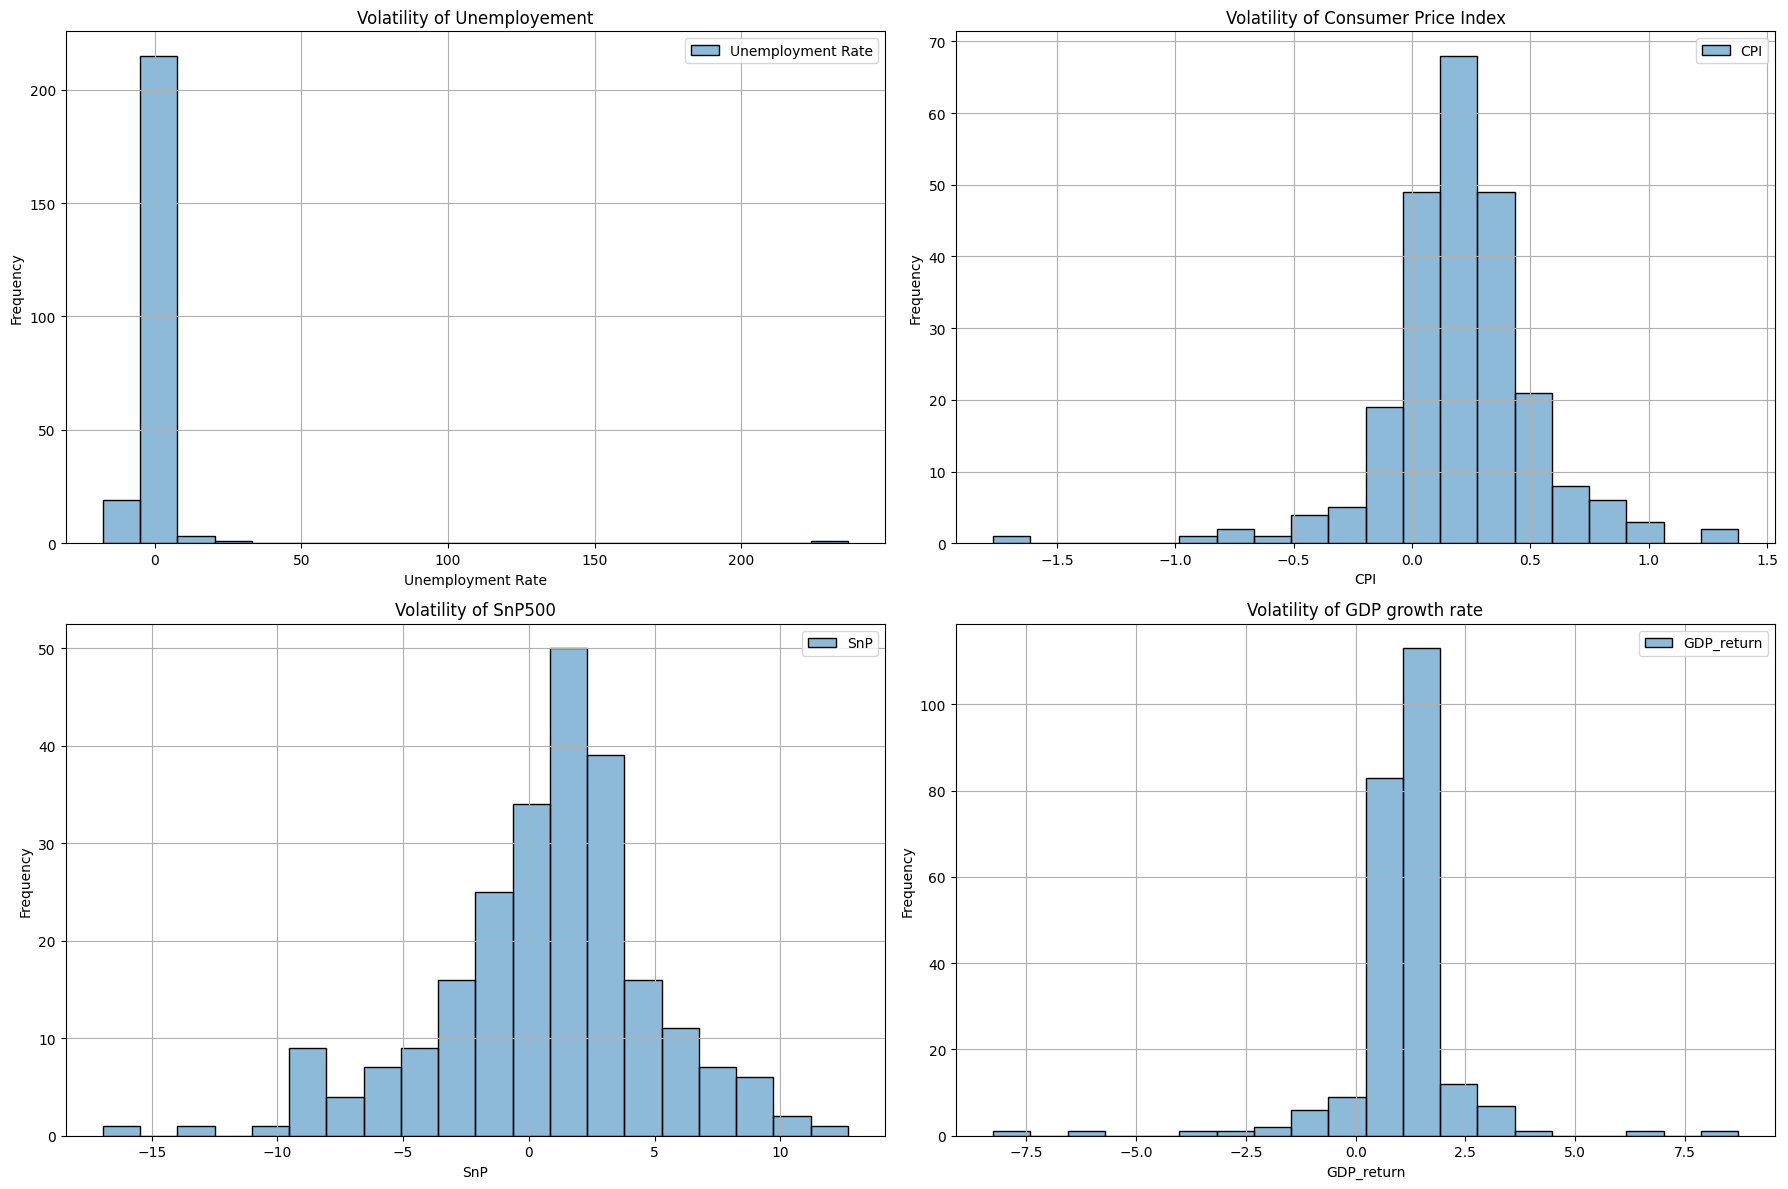

In [88]:
unemployement_title = 'Volatility of Unemployement'
CPI_title = 'Volatility of Consumer Price Index'
SnP_title = 'Volatility of SnP500'
GDP_title = 'Volatility of GDP growth rate'

plot_data = [
    (return_df[['Unemployment Rate']], unemployement_title),
    (return_df[['CPI']], CPI_title),
    (return_df[['SnP']], SnP_title),
    (return_df[['GDP_return']], GDP_title)
]
plot_economic_distributions(*plot_data)

In this script, we are creating KDE (Kernel Density Estimate) plots to visualize the distribution of volatility for several economic indicators. Each plot shows the density of volatility values, helping us understand the variability and concentration of different levels of volatility for indicators like Unemployement rate, consumer price index, S&P 500 close price, and GDP growth rate.

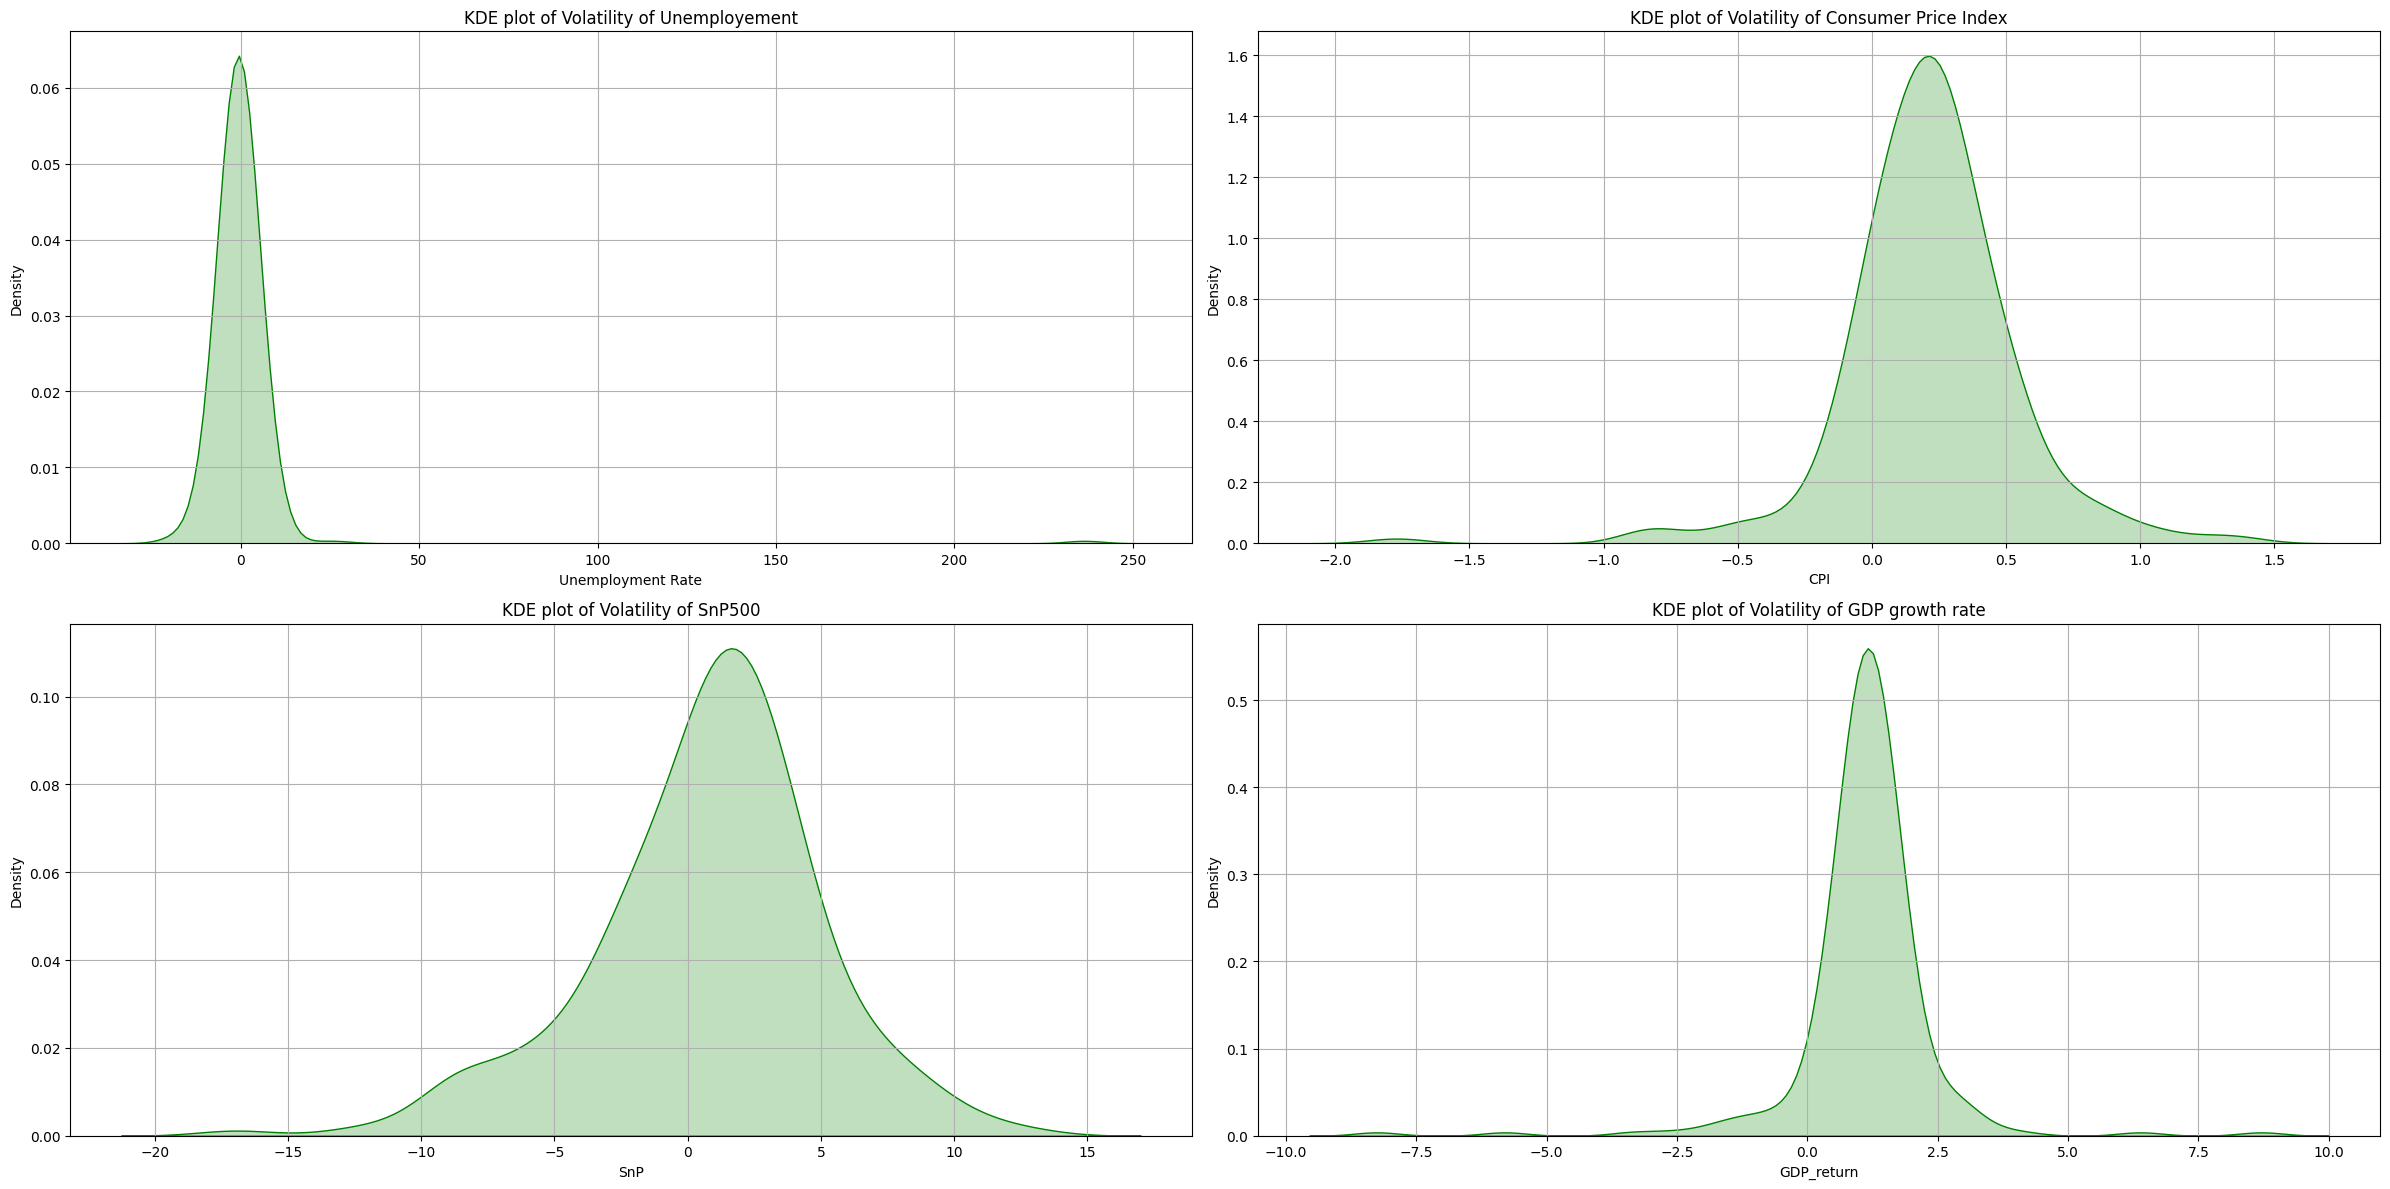

In [89]:
unemployement_title = 'KDE plot of Volatility of Unemployement'
CPI_title = 'KDE plot of Volatility of Consumer Price Index'
SnP_title = 'KDE plot of Volatility of SnP500'
GDP_title = 'KDE plot of Volatility of GDP growth rate'


plot_kde(
    return_df,unemployement_title, 'Unemployment Rate',
    return_df, CPI_title , 'CPI',
    return_df, SnP_title, 'SnP',
    return_df, GDP_title, 'GDP_return',
)

In this script, we are creating a correlation heatmap to show the relationships between the volatilities of various economic indicators and S&P500. The heatmap displays the correlation coefficients between each pair of indicators, helping us understand how closely related their volatilities are. This visualization makes it easy to see which indicators move together and which ones do not.

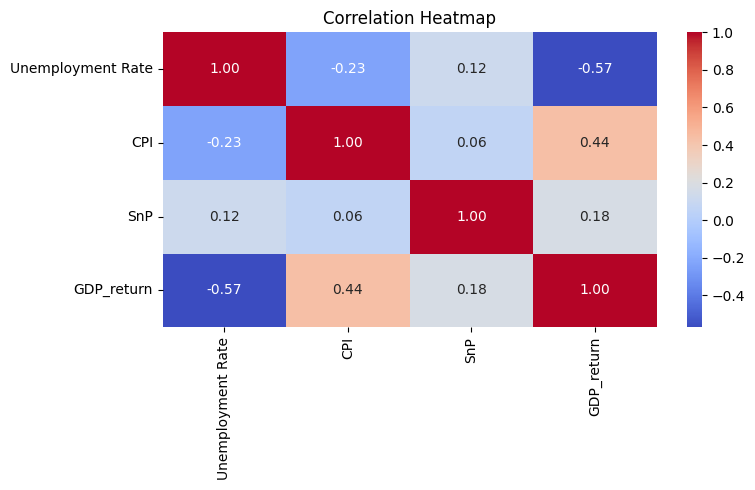

In [90]:
corr(return_df)

In [91]:
return_df.describe().T

count      mean        std        min       25%       50%  \
Unemployment Rate  239.0  0.379070  15.819990 -17.647059 -2.439024  0.000000   
CPI                239.0  0.212110   0.325445  -1.770548  0.054219  0.214707   
SnP                239.0  0.697484   4.305980 -16.941015 -1.746800  1.215086   
GDP_return         239.0  1.099714   1.289986  -8.261898  0.802911  1.131559   

                        75%         max  
Unemployment Rate  1.564027  236.363636  
CPI                0.371338    1.376849  
SnP                3.248676   12.682814  
GDP_return         1.546700    8.710313

In this script, we calculated the correlations between the volatilities of various macroeconomic indicators and S&P500 returns data using the Pearson correlation coefficient.The correlation between GDP returns and the SnP is statistically significant, indicating that changes in GDP are associated with changes in the SnP. A low p-value of 0.0062 suggests a strong likelihood that this relationship is not due to random chance.

In [92]:
macro_data = ['GDP_return', 'Unemployment Rate', 'CPI']
equity_data = ['SnP']
correlations, p_values = calculate_correlations(return_df, macro_data, equity_data)

GDP_return vs SnP: Correlation = 0.18, P-value = 0.0062
   The correlation is statistically significant.
Unemployment Rate vs SnP: Correlation = 0.12, P-value = 0.0696
   The correlation is not statistically significant.
CPI vs SnP: Correlation = 0.06, P-value = 0.3217
   The correlation is not statistically significant.


In this script, we use pair plot a valuable tool for preliminary data analysis, allowing us to quickly assess potential correlations and the overall structure of the data. This visualization aids in understanding how different macroeconomic indicators and credit metrics interact with each other.

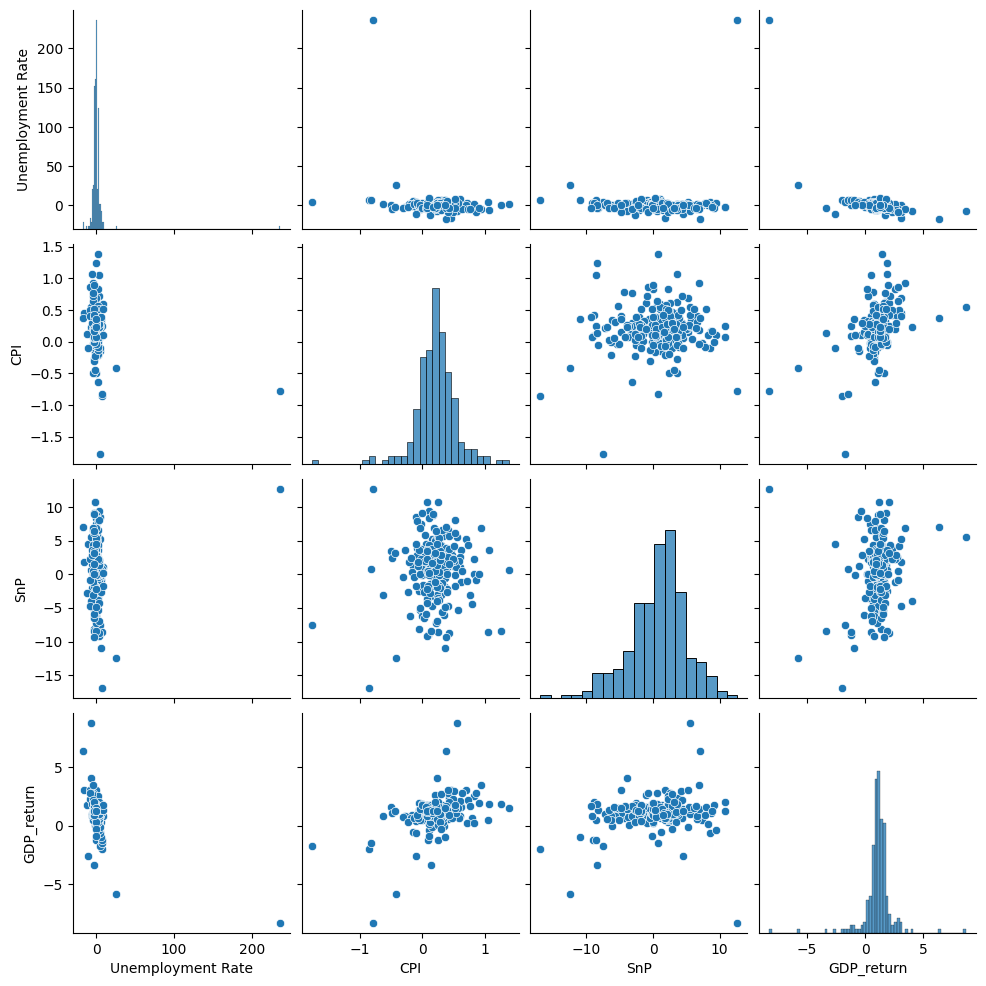

In [93]:
sns.pairplot(return_df)

In [94]:
stationary_volatility_df = make_stationary(return_df)

ADF statistics for Unemployment Rate: -14.301910417046516
p-value for Unemployment Rate: 1.2249826648648425e-26
Critical Value 1%: -3.458128284586202
Critical Value 5%: -2.873761835239286
Critical Value 10%: -2.5732834559706235
Unemployment Rate is stationary

ADF statistics for CPI: -2.6938725666878907
p-value for CPI: 0.07510459774689744
Critical Value 1%: -3.459884913337196
Critical Value 5%: -2.8745310704320794
Critical Value 10%: -2.573693840082908
CPI is not stationary

ADF statistics for CPI: -7.0334469627701
p-value for CPI: 6.101243620010884e-10
Critical Value 1%: -3.459884913337196
Critical Value 5%: -2.8745310704320794
Critical Value 10%: -2.573693840082908
CPI is stationary

ADF statistics for SnP: -6.467321634155026
p-value for SnP: 1.394787678436912e-08
Critical Value 1%: -3.458731141928624
Critical Value 5%: -2.8740258764297293
Critical Value 10%: -2.5734243167124093
SnP is stationary

ADF statistics for GDP_return: -2.848609553722352
p-value for GDP_return: 0.0516586936

In this script, we conducted Granger causality tests to explore potential causal relationships between macroeconomic indicators and S&P500 returns. Granger causality tests help determine if past values of one variable (macroeconomic indicator) can help predict S&P500 returns.

Granger causality helps us understand if changes in macroeconomic indicators can predict changes in S&P500 returns. This insight is crucial for financing team to forecaste and provide evidence of potential causal links between economic factors and S&P500 behavior.

In [95]:
max_lag = 20
report, best_results = granger_causality_report(return_df, macro_data, equity_data, max_lag)

df_report = pd.DataFrame(report, index=[f"Lag {lag}" for lag in range(1, max_lag + 1)])
df_report = df_report.transpose()

df_report.head(10)

Lag 1     Lag 2     Lag 3     Lag 4     Lag 5  \
GDP_return->SnP         0.250370  0.031083  0.055865  0.068068  0.013128   
Unemployment Rate->SnP  0.425239  0.877701  0.662002  0.436894  0.358843   
CPI->SnP                0.752327  0.803344  0.303396  0.186267  0.232397   

                           Lag 6     Lag 7     Lag 8     Lag 9    Lag 10  \
GDP_return->SnP         0.022932  0.053172  0.080203  0.186096  0.181517   
Unemployment Rate->SnP  0.395630  0.193867  0.211887  0.365393  0.431414   
CPI->SnP                0.052323  0.028886  0.022064  0.073474  0.104426   

                          Lag 11    Lag 12    Lag 13    Lag 14    Lag 15  \
GDP_return->SnP         0.251107  0.228040  0.283733  0.408371  0.245869   
Unemployment Rate->SnP  0.503281  0.543414  0.585429  0.761164  0.658302   
CPI->SnP                0.067794  0.097273  0.059277  0.080764  0.136917   

                          Lag 16    Lag 17    Lag 18    Lag 19    Lag 20  
GDP_return->SnP         0.063597  0.079327  0.117906  0.087881  0.133989  
Unemployment Rate->SnP  0.716496  0.733183  0.578728  0.606965  0.553795  
CPI->SnP                0.177146  0.244979  0.290388  0.343486  0.308559

In [96]:
best_results_df = pd.DataFrame(best_results, columns=['Macro Variable', 'Equity Variable', 'Min P-Value', 'Best Lag'])
best_results_df

Macro Variable Equity Variable  Min P-Value  Best Lag
0     GDP_return             SnP     0.013128         5
1            CPI             SnP     0.022064         8

<h1>Scenario 4 - Publicly traded bonds (Treasury Bonds)

In this analysis, we will look at how different economic factors are connected to Corporate Bonds. We want to see how things like Unemployment Rate, High Yield Index Option-Adjusted Spread, Market Yield on U.S. Treasury Securities and Corporate Bond Yield affect each other. This will help us understand how these factors influence AAA rated corporate bond yield.

We will use data from reliable sources like the Federal Reserve Economic Data (FRED) and other financial databases. With Python, we will bring in this data, create visualizations, and analyze it. We will make graphs to show changes over time, how data is spread out, and how different factors are related.

Our main goal is to find out if changes in other macro economic factors and bond market can cause changes in AAA rated corporate bond yield. To do this, we will use a Granger causality test, which helps us understand if one thing can predict another.

In [97]:
option_spread_df = macroeconomic_datas("Publicly Traded Bond/ICE BofA US High Yield Index Option-Adjusted Spread.csv",
                                      ['option_spread'])

(240, 1)
          option_spread
DATE                   
1/1/2004       3.940000
2/1/2004       4.258571
3/1/2004       4.401739
4/1/2004       3.975238
5/1/2004       4.250952


In [98]:
UR_df = macroeconomic_datas("Publicly Traded Bond/Unemployment Rate.csv",
                           ['Unemployment Rate'])

(240, 1)
          Unemployment Rate
DATE                       
1/1/2004                5.7
2/1/2004                5.6
3/1/2004                5.8
4/1/2004                5.6
5/1/2004                5.6


In [99]:
corporate_bond_df = macroeconomic_datas("Publicly Traded Bond/Moody's Seasoned Aaa Corporate Bond Yield.csv",
                                       ['CB_yield'])

(240, 1)
          CB_yield
DATE              
1/1/2004  5.536000
2/1/2004  5.500526
3/1/2004  5.325652
4/1/2004  5.730952
5/1/2004  6.037500


In [100]:
US_treasuries_df = macroeconomic_datas("Publicly Traded Bond/Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity.csv",
                                      ['US_T_Yield'])


(240, 1)
          US_T_Yield
DATE                
1/1/2004    4.150500
2/1/2004    4.084211
3/1/2004    3.826522
4/1/2004    4.347619
5/1/2004    4.715500


In this script, we're putting a function to plot multiple economic datasets on separate graphs. Each plot shows a different economic indicator over time, with a red dashed line marking the average value for that indicator. After defining the function, we use it to visualize data like Unemployment Rate, High Yield Index Option-Adjusted Spread, Market Yield on U.S. Treasury Securities and Corporate Bond Yield from 2004 to 2023.

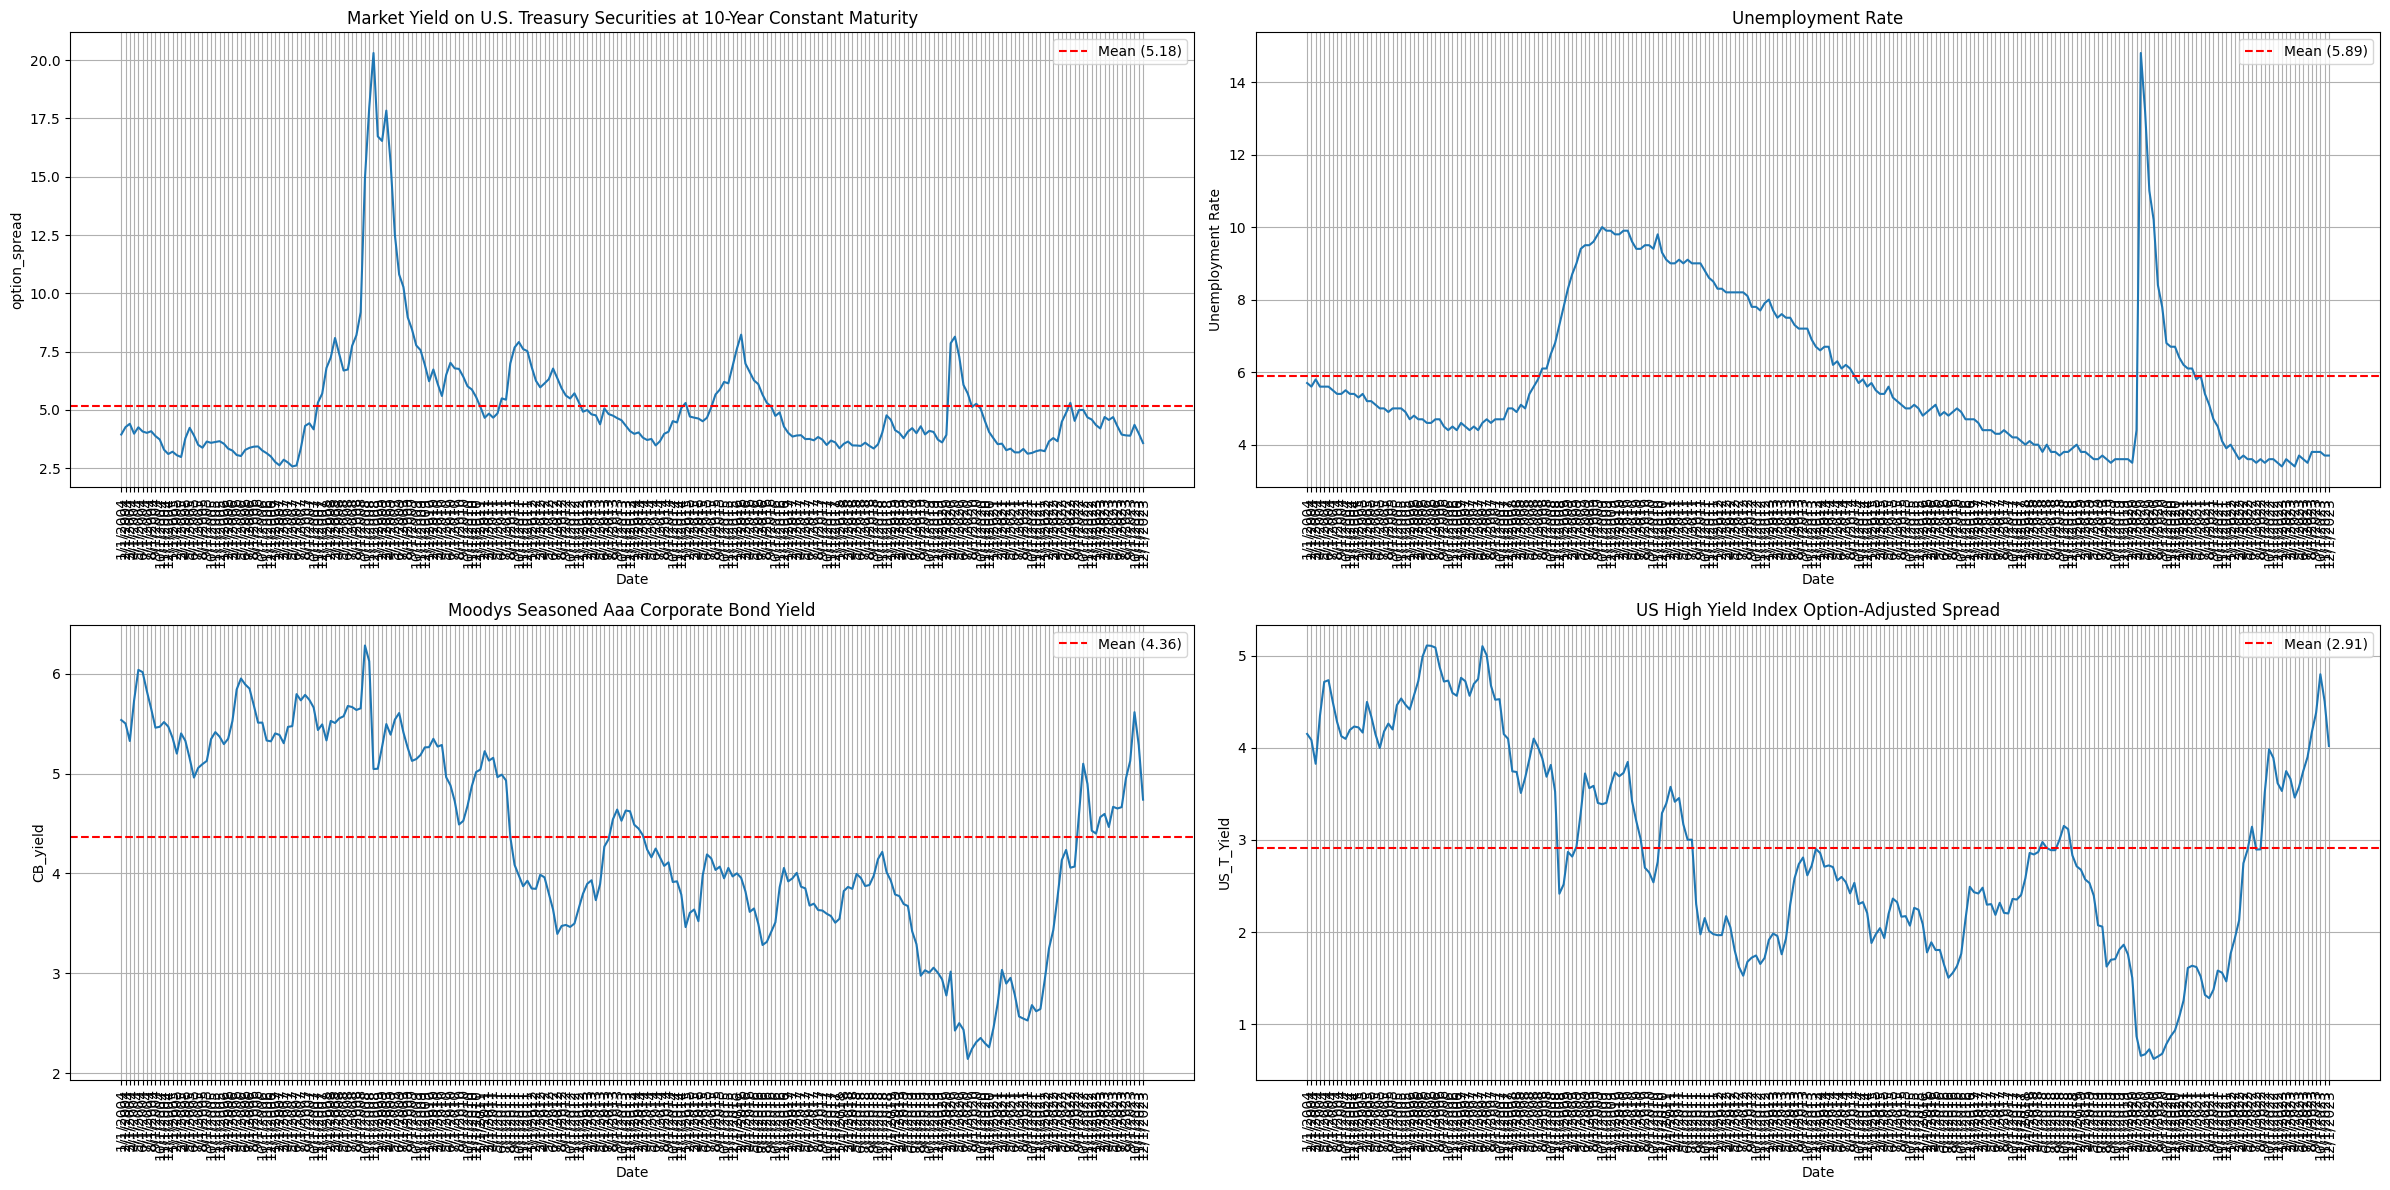

In [101]:
plot_economic_data(
    (option_spread_df, 'Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity'),
    (UR_df, 'Unemployment Rate'),
    (corporate_bond_df, 'Moodys Seasoned Aaa Corporate Bond Yield'),
    (US_treasuries_df, 'US High Yield Index Option-Adjusted Spread')
)

In [102]:
return_df = volatility(option_spread_df, UR_df, corporate_bond_df, US_treasuries_df)
return_df.head()

option_spread  Unemployment Rate  CB_yield  US_T_Yield
DATE                                                            
2/1/2004       8.085569          -1.754386 -0.640782   -1.597144
3/1/2004       3.361872           3.571429 -3.179226   -6.309390
4/1/2004      -9.689376          -3.448276  7.610339   13.618041
5/1/2004       6.935793           0.000000  5.348982    8.461665
6/1/2004      -4.278135           0.000000 -0.376614    0.388284

In this script, we're putting our volatility function to plot the volatility of Unemployment Rate, High Yield Index Option-Adjusted Spread, Market Yield on U.S. Treasury Securities and Corporate Bond Yield. We calculate the rolling standard deviation (volatility) for each dataset and standardize the results to make them comparable. Then, we plot these standardized volatilities on a single graph to show how they change over time.

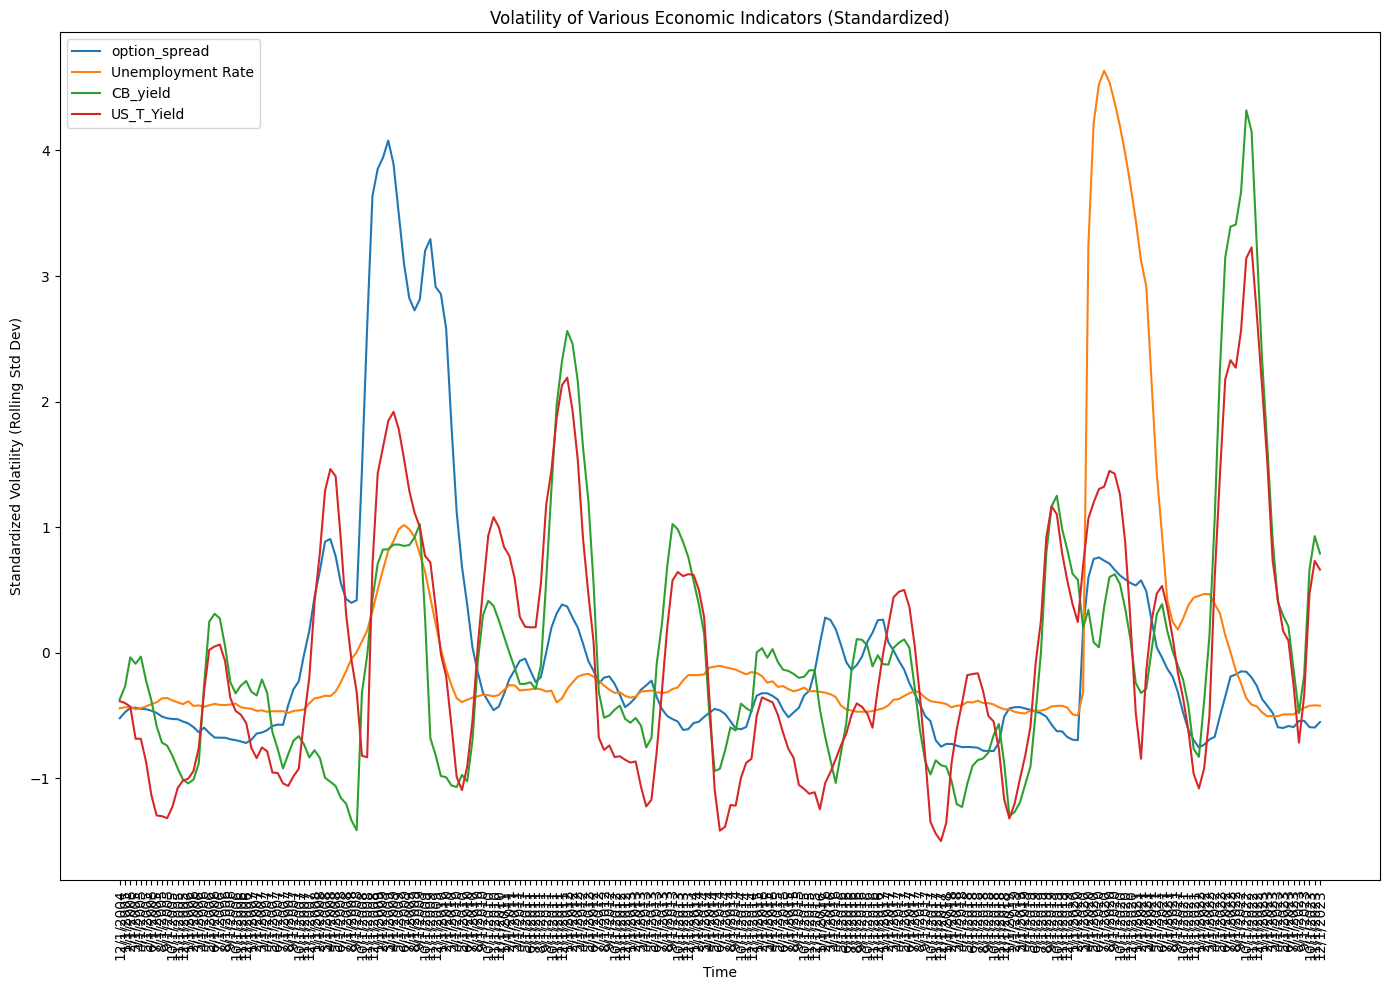

In [103]:
volatility_chart(option_spread_df, UR_df, corporate_bond_df, US_treasuries_df)

In this script, we are creating histograms to check the distribution of volatility for several economic indicators. Each histogram shows how frequently different levels of volatility occur for indicators like Unemployment Rate, High Yield Index Option-Adjusted Spread, Market Yield on U.S. Treasury Securities and Corporate Bond Yield . This helps us understand the variability and distribution of these economic factors over time.

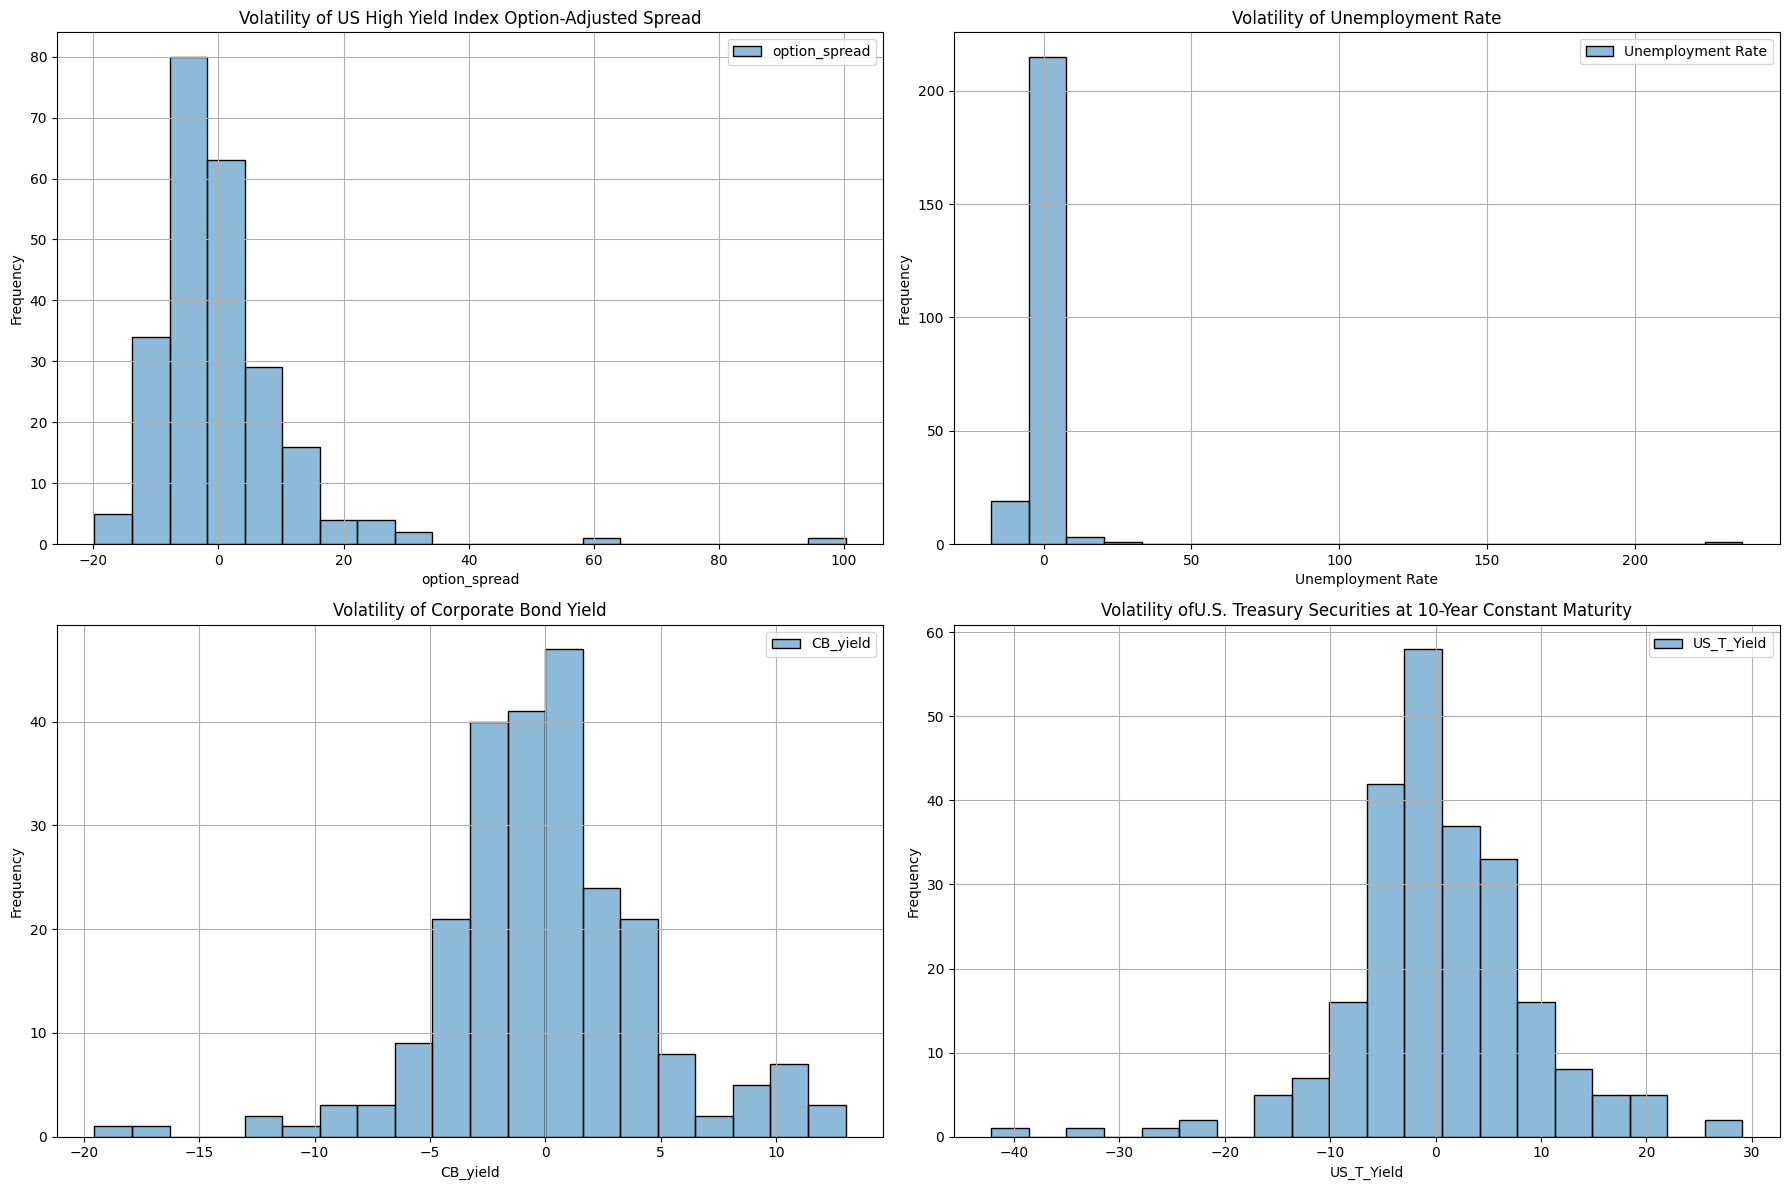

In [104]:
OS_title = 'Volatility of US High Yield Index Option-Adjusted Spread'
UR_title = 'Volatility of Unemployment Rate'
CB_title = 'Volatility of Corporate Bond Yield'
US_T_title = 'Volatility ofU.S. Treasury Securities at 10-Year Constant Maturity'

plot_data = [
    (return_df[['option_spread']], OS_title),
    (return_df[['Unemployment Rate']], UR_title),
    (return_df[['CB_yield']], CB_title),
    (return_df[['US_T_Yield']], US_T_title)
]
plot_economic_distributions(*plot_data)

In this script, we are creating KDE (Kernel Density Estimate) plots to visualize the distribution of volatility for several economic indicators. Each plot shows the density of volatility values, helping us understand the variability and concentration of different levels of volatility for indicators likeUnemployment Rate, High Yield Index Option-Adjusted Spread, Market Yield on U.S. Treasury Securities and Corporate Bond Yield.

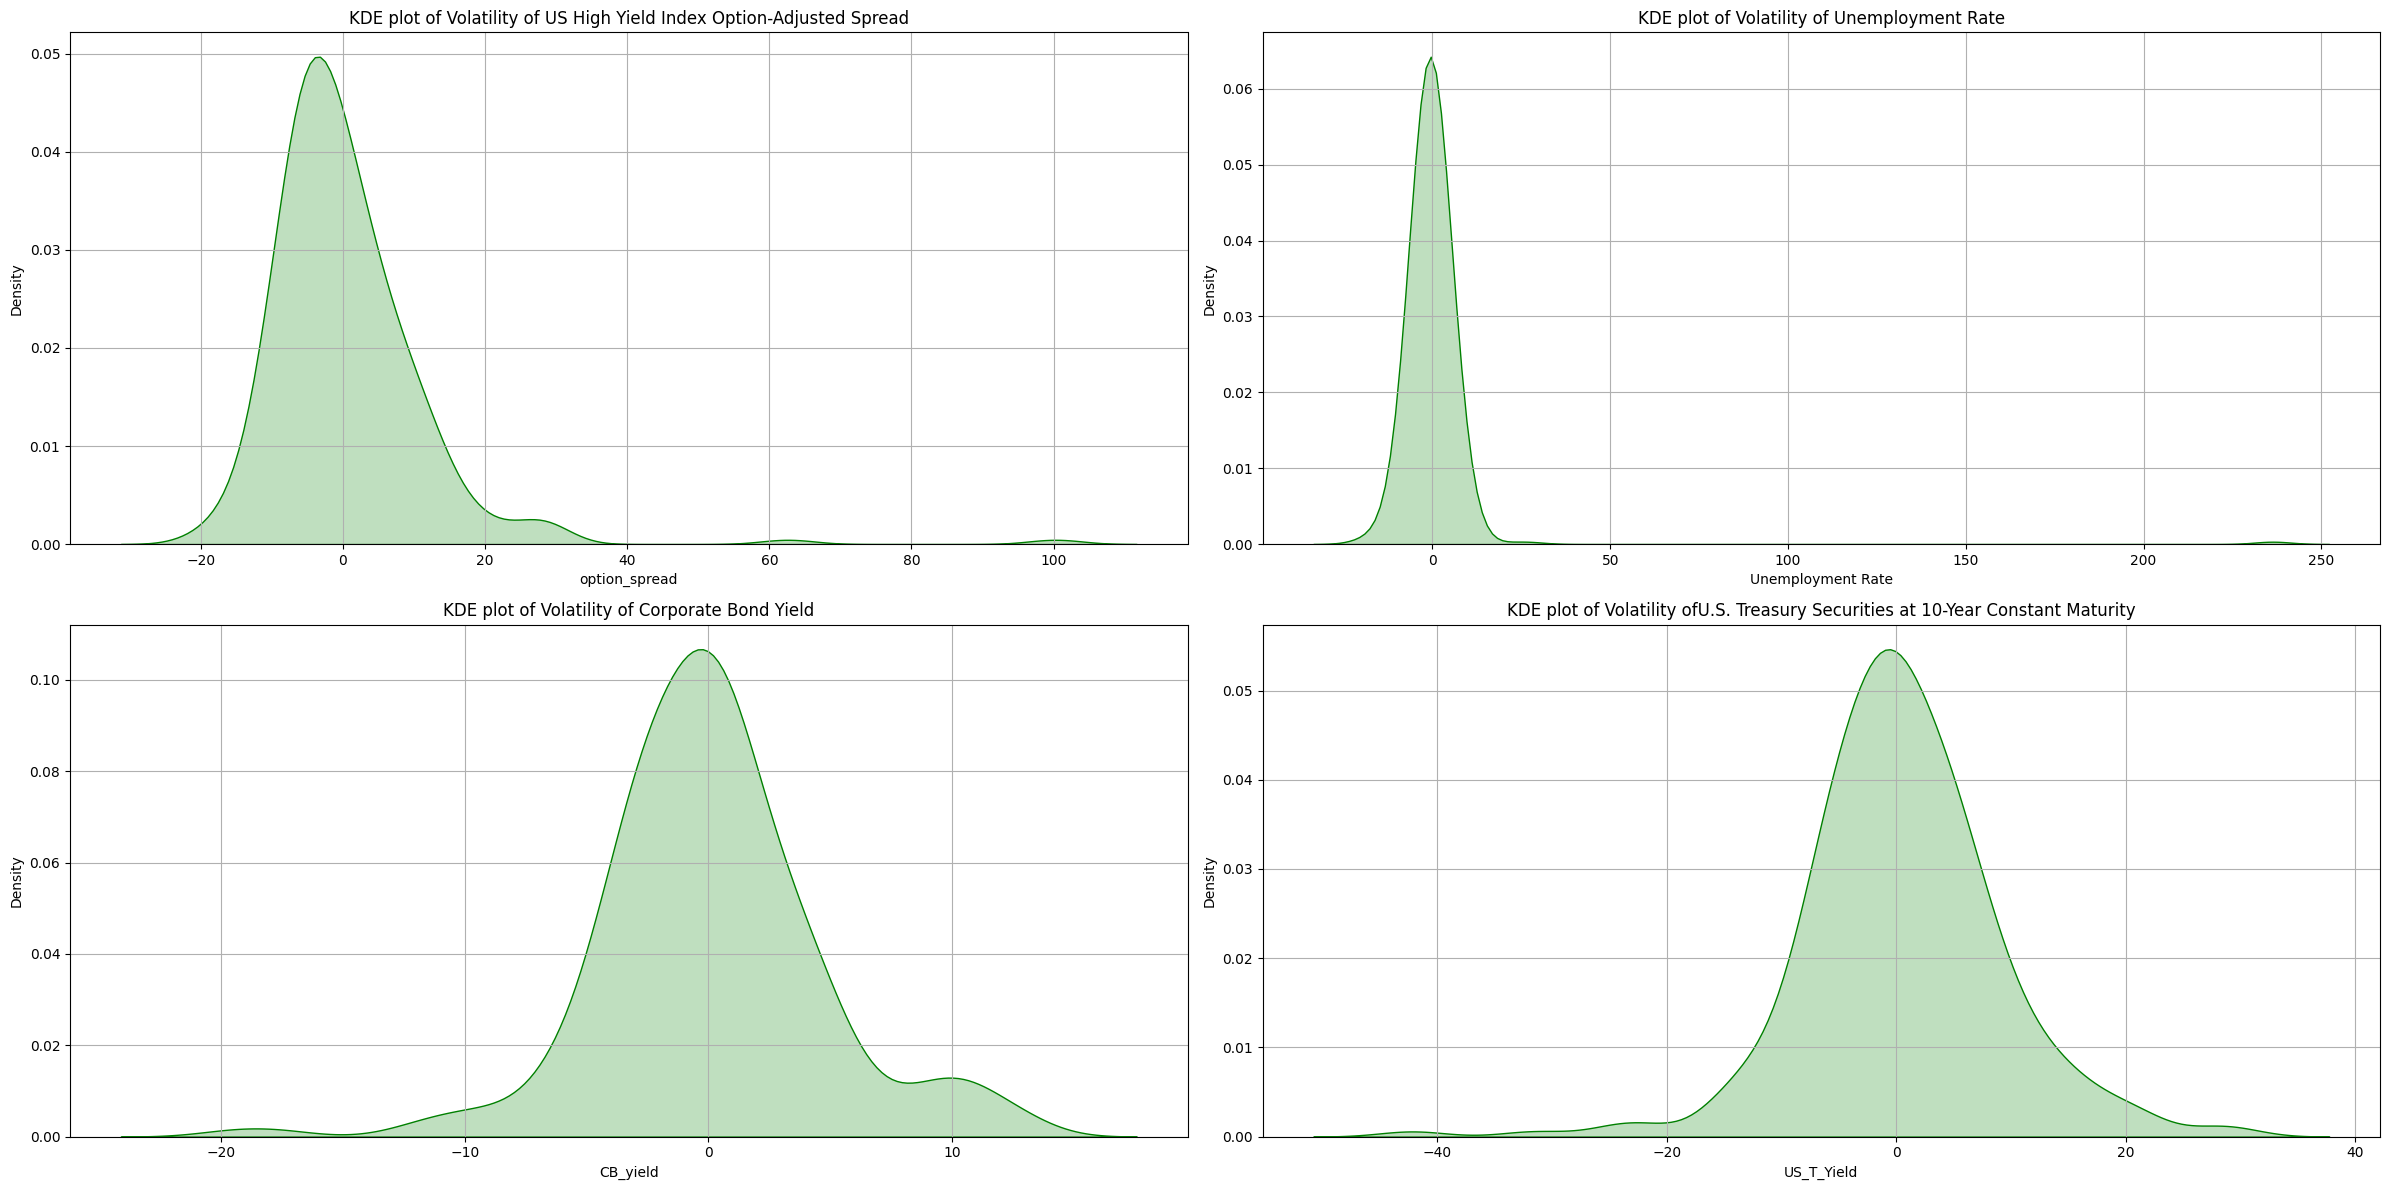

In [105]:
OS_title = 'KDE plot of Volatility of US High Yield Index Option-Adjusted Spread'
UR_title = 'KDE plot of Volatility of Unemployment Rate'
CB_title = 'KDE plot of Volatility of Corporate Bond Yield'
US_T_title = 'KDE plot of Volatility ofU.S. Treasury Securities at 10-Year Constant Maturity'

plot_kde(
    return_df, OS_title, 'option_spread',
    return_df, UR_title , 'Unemployment Rate',
    return_df, CB_title, 'CB_yield',
    return_df, US_T_title, 'US_T_Yield',
)

In this script, we are creating a correlation heatmap to show the relationships between the volatilities of various economic indicators and bond indicators. The heatmap displays the correlation coefficients between each pair of indicators, helping us understand how closely related their volatilities are. This visualization makes it easy to see which indicators move together and which ones do not.

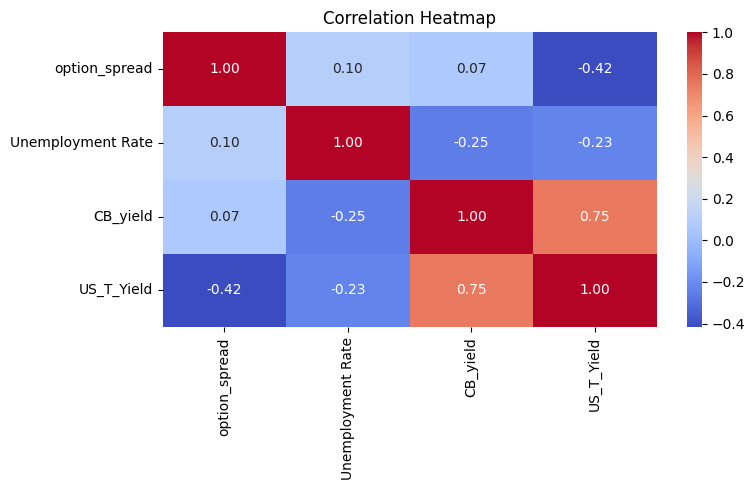

In [106]:
corr(return_df)

In [107]:
return_df.describe().T

count      mean        std        min       25%       50%  \
option_spread      239.0  0.487893  11.385303 -19.816783 -5.833951 -1.573067   
Unemployment Rate  239.0  0.379070  15.819990 -17.647059 -2.439024  0.000000   
CB_yield           239.0  0.039727   4.567482 -19.535284 -2.561392 -0.158553   
US_T_Yield         239.0  0.371527   8.603596 -42.162351 -4.613599 -0.071162   

                        75%         max  
option_spread      3.936079  100.262153  
Unemployment Rate  1.564027  236.363636  
CB_yield           2.128385   13.009032  
US_T_Yield         4.816547   29.122395

In this script, we calculated the correlations between the volatilities of macroeconomic indicators and bond market data using the Pearson correlation coefficient.The correlation between US Treasury Yield and Corporate Bond Yield is highly significant, with a correlation coefficient of 0.75 and a p-value of 0.0000. This indicates a strong positive relationship between these two variables, suggesting that changes in US Treasury Yields are closely associated with changes in Corporate Bond Yields.

In [108]:
macro_data = ['option_spread', 'Unemployment Rate', 'US_T_Yield']
bond_data = ['CB_yield']
correlations, p_values = calculate_correlations(return_df, macro_data, bond_data)

option_spread vs CB_yield: Correlation = 0.07, P-value = 0.2912
   The correlation is not statistically significant.
Unemployment Rate vs CB_yield: Correlation = -0.25, P-value = 0.0001
   The correlation is statistically significant.
US_T_Yield vs CB_yield: Correlation = 0.75, P-value = 0.0000
   The correlation is statistically significant.


In this script, we use pair plot a valuable tool for preliminary data analysis, allowing us to quickly assess potential correlations and the overall structure of the data. This visualization aids in understanding how different macroeconomic indicatorsa and bond market indicators interact with each other.

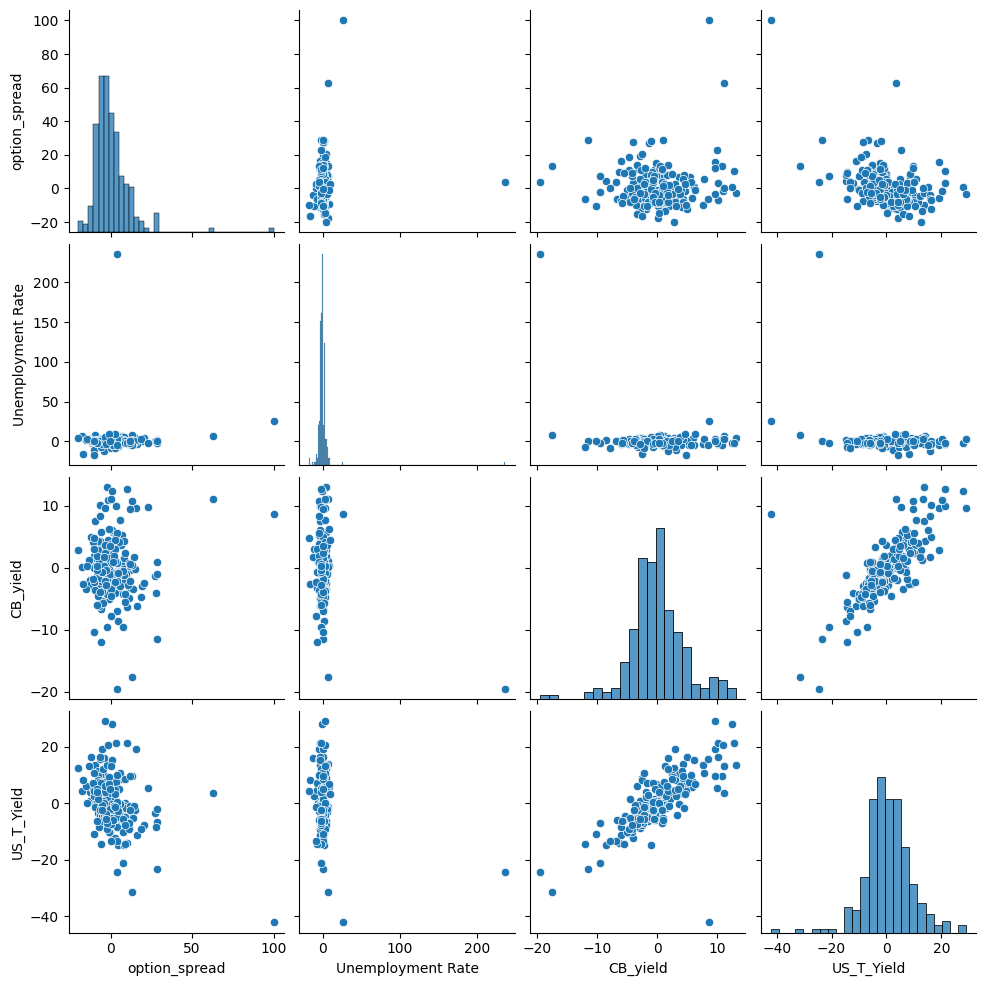

In [109]:
sns.pairplot(return_df)

In [110]:
stationary_volatility_df = make_stationary(return_df)

ADF statistics for option_spread: -12.059414454347513
p-value for option_spread: 2.4894444369622755e-22
Critical Value 1%: -3.458128284586202
Critical Value 5%: -2.873761835239286
Critical Value 10%: -2.5732834559706235
option_spread is stationary

ADF statistics for Unemployment Rate: -14.301910417046516
p-value for Unemployment Rate: 1.2249826648648425e-26
Critical Value 1%: -3.458128284586202
Critical Value 5%: -2.873761835239286
Critical Value 10%: -2.5732834559706235
Unemployment Rate is stationary

ADF statistics for CB_yield: -12.430971385347103
p-value for CB_yield: 3.941251799714414e-23
Critical Value 1%: -3.458128284586202
Critical Value 5%: -2.873761835239286
Critical Value 10%: -2.5732834559706235
CB_yield is stationary

ADF statistics for US_T_Yield: -10.653995601339512
p-value for US_T_Yield: 4.583992829879254e-19
Critical Value 1%: -3.458128284586202
Critical Value 5%: -2.873761835239286
Critical Value 10%: -2.5732834559706235
US_T_Yield is stationary



In this script, we conducted Granger causality tests to explore potential causal relationships between macroeconomic indicators and bond market variables with AAA graded corpoarte bond yield using volatility data. Granger causality tests help determine if past values of one variable (macroeconomic indicator/bond market variables) can help predict corporate bond yield.

Granger causality helps us understand if changes in macroeconomic indicators/bond market variable can predict changes in corporate bond yiled. This insight is crucial for financing team to analysis, forecaste, and provide evidence of potential causal links between economic factors and corporate bond yield.

In [111]:
max_lag = 20
report, best_results = granger_causality_report(return_df, macro_data, bond_data, max_lag)

df_report = pd.DataFrame(report, index=[f"Lag {lag}" for lag in range(1, max_lag + 1)])
df_report = df_report.transpose()

df_report.head(10)

Lag 1     Lag 2     Lag 3     Lag 4     Lag 5  \
option_spread->CB_yield      0.000012  0.000082  0.000204  0.000535  0.000364   
Unemployment Rate->CB_yield  0.302994  0.296632  0.027295  0.040737  0.081598   
US_T_Yield->CB_yield         0.000813  0.001394  0.002324  0.000794  0.002154   

                                Lag 6     Lag 7     Lag 8     Lag 9    Lag 10  \
option_spread->CB_yield      0.000904  0.000831  0.000325  0.000529  0.000732   
Unemployment Rate->CB_yield  0.146067  0.096553  0.098041  0.092312  0.075629   
US_T_Yield->CB_yield         0.004544  0.008000  0.011825  0.015584  0.024802   

                               Lag 11    Lag 12    Lag 13    Lag 14    Lag 15  \
option_spread->CB_yield      0.001459  0.000382  0.000491  0.000754  0.001468   
Unemployment Rate->CB_yield  0.007804  0.015322  0.027912  0.017543  0.023041   
US_T_Yield->CB_yield         0.021130  0.006908  0.008237  0.013069  0.005018   

                               Lag 16    Lag 17    Lag 18    Lag 19    Lag 20  
option_spread->CB_yield      0.001467  0.001563  0.001624  0.003332  0.003292  
Unemployment Rate->CB_yield  0.040053  0.052300  0.045145  0.029128  0.034160  
US_T_Yield->CB_yield         0.002740  0.003038  0.002309  0.003485  0.002569

In [112]:
best_results_df = pd.DataFrame(best_results, columns=['Macro Variable', 'Bond Variable', 'Min P-Value', 'Best Lag'])
best_results_df

Macro Variable Bond Variable  Min P-Value  Best Lag
0      option_spread      CB_yield     0.000012         1
1  Unemployment Rate      CB_yield     0.007804        11
2         US_T_Yield      CB_yield     0.000794         4